In [1]:
from tensorflow.keras.utils import plot_model

## Dense + FC

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from scipy.linalg import sqrtm
import numpy as np
import time
import matplotlib.pyplot as plt

np.random.seed(1000)
tf.random.set_seed(1000)

# input 100
# output 28*28*1

def build_generator():
    model = Sequential()
    
    # increase the dimension
    model.add(Dense(256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(28*28, activation='tanh'))
    model.add(Reshape((28, 28, 1)))

    return model

# input 28*28*1
# output 1

def build_discriminator():
    model = Sequential()
    
    model.add(Flatten(input_shape=(28, 28, 1)))
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Dense(1, activation='sigmoid'))

    return model

# Load and preprocess the MNIST dataset
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)

# Calculate FID function
def calculate_fid(real_images, fake_images):
    act1 = real_images.reshape((real_images.shape[0], -1))
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    
    act2 = fake_images.reshape((fake_images.shape[0], -1))
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

def train_gan(epochs=1000, batch_size=64, p_epoch=100):
    generator = build_generator()
    discriminator = build_discriminator()

    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    half_batch = int(batch_size / 2)
    
    d_losses = []
    g_losses = []
    d_acc = []
    fid_scores = []  # List to store FID scores
    
    start_time = time.time()  # Record the start time

    for epoch in range(epochs):
        # Select a random half batch of real images
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        # Generate a half batch of new fake images
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        # Train the discriminator
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_y)

        # Record the losses
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_acc.append(d_loss[1] * 100)
        
        # Calculate and print FID every p_epoch epochs
        if epoch % p_epoch == 0:
            noise = np.random.normal(0, 1, (1000, 100))
            fake_images = generator.predict(noise)
            fid = calculate_fid(x_train[:1000], fake_images)
            fid_scores.append(fid)
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}] [FID: {fid}]")

    end_time = time.time()  # Record the end time
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    return generator, d_losses, g_losses, d_acc, fid_scores

In [3]:
generator_dense = build_generator()
generator_dense.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                       

In [4]:
discriminator_dense = build_discriminator()
discriminator_dense.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               401920    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)              

In [7]:
generator_fc, d_losses, g_losses, d_acc, fid_scores_fc = train_gan(epochs=3000, batch_size=64, p_epoch=100)

32/32 [==============================] - 0s 3ms/step
0 [D loss: 0.7555400133132935, acc.: 32.8125%] [G loss: 0.7487839460372925] [FID: 702.5110268518392]
32/32 [==============================] - 0s 2ms/step
100 [D loss: 0.007341633725445718, acc.: 100.0%] [G loss: 4.694519996643066] [FID: 858.7747928054524]
32/32 [==============================] - 0s 2ms/step
200 [D loss: 0.062025170773267746, acc.: 96.875%] [G loss: 4.640584945678711] [FID: 706.7180299726447]
32/32 [==============================] - 0s 2ms/step
300 [D loss: 0.21721000596880913, acc.: 90.625%] [G loss: 2.8823351860046387] [FID: 435.99247717083176]
1/1 [==============================] - 0s 8ms/step


32/32 [==============================] - 0s 2ms/step
400 [D loss: 0.7818388640880585, acc.: 43.75%] [G loss: 0.9311320781707764] [FID: 223.41712392227345]
32/32 [==============================] - 0s 2ms/step
500 [D loss: 0.6861721575260162, acc.: 37.5%] [G loss: 0.672410249710083] [FID: 179.9267770318472]
32/32 [==============================] - 0s 2ms/step
600 [D loss: 0.6402031481266022, acc.: 54.6875%] [G loss: 0.6692895889282227] [FID: 165.33171879270176]
1/1 [==============================] - 0s 10ms/step


32/32 [==============================] - 0s 2ms/step
700 [D loss: 0.6447049677371979, acc.: 57.8125%] [G loss: 0.7332214117050171] [FID: 155.338954007357]
32/32 [==============================] - 0s 2ms/step
800 [D loss: 0.6456483900547028, acc.: 60.9375%] [G loss: 0.7020237445831299] [FID: 146.15617807987113]
32/32 [==============================] - 0s 2ms/step
900 [D loss: 0.6245808005332947, acc.: 60.9375%] [G loss: 0.7081669569015503] [FID: 138.76116177484303]
1/1 [==============================] - 0s 9ms/step


32/32 [==============================] - 0s 2ms/step
1000 [D loss: 0.6188404858112335, acc.: 67.1875%] [G loss: 0.7689297199249268] [FID: 131.4151742690845]
1/1 [==============================] - 0s 9ms/step


32/32 [==============================] - 0s 2ms/step
1100 [D loss: 0.6458024382591248, acc.: 64.0625%] [G loss: 0.7636138796806335] [FID: 129.63559329692305]
32/32 [==============================] - 0s 2ms/step
1200 [D loss: 0.6563660502433777, acc.: 64.0625%] [G loss: 0.758033037185669] [FID: 121.54370077684078]
32/32 [==============================] - 0s 2ms/step
1300 [D loss: 0.6380297541618347, acc.: 67.1875%] [G loss: 0.7724242210388184] [FID: 121.31848818244526]
1/1 [==============================] - 0s 10ms/step


32/32 [==============================] - 0s 2ms/step
1400 [D loss: 0.6122022867202759, acc.: 60.9375%] [G loss: 0.7957947850227356] [FID: 122.44244584589498]
32/32 [==============================] - 0s 2ms/step
1500 [D loss: 0.6881192028522491, acc.: 53.125%] [G loss: 0.781456708908081] [FID: 121.10904338463244]
32/32 [==============================] - 0s 2ms/step
1600 [D loss: 0.6747583746910095, acc.: 54.6875%] [G loss: 0.7842810153961182] [FID: 110.28779767710631]
32/32 [==============================] - 0s 2ms/step
1700 [D loss: 0.6357449889183044, acc.: 59.375%] [G loss: 0.8471309542655945] [FID: 110.44875845587814]


32/32 [==============================] - 0s 2ms/step
1800 [D loss: 0.5957335531711578, acc.: 68.75%] [G loss: 0.8475115895271301] [FID: 102.20745000468985]
32/32 [==============================] - 0s 2ms/step
1900 [D loss: 0.6104825139045715, acc.: 73.4375%] [G loss: 0.8639267683029175] [FID: 101.48072051489896]
32/32 [==============================] - 0s 2ms/step
2000 [D loss: 0.6577426195144653, acc.: 57.8125%] [G loss: 0.9504212141036987] [FID: 104.95512031630753]
1/1 [==============================] - 0s 10ms/step


32/32 [==============================] - 0s 2ms/step
2100 [D loss: 0.5753966271877289, acc.: 71.875%] [G loss: 0.8491982817649841] [FID: 96.53249850811754]
32/32 [==============================] - 0s 2ms/step
2200 [D loss: 0.619879275560379, acc.: 70.3125%] [G loss: 0.8359063863754272] [FID: 88.76575746373018]
32/32 [==============================] - 0s 2ms/step
2300 [D loss: 0.6150653958320618, acc.: 70.3125%] [G loss: 0.8680646419525146] [FID: 87.93597716344976]
1/1 [==============================] - 0s 7ms/step


32/32 [==============================] - 0s 2ms/step
2400 [D loss: 0.6218245327472687, acc.: 67.1875%] [G loss: 0.8959149122238159] [FID: 85.752102159585]
32/32 [==============================] - 0s 2ms/step
2500 [D loss: 0.6762814819812775, acc.: 59.375%] [G loss: 0.8907026052474976] [FID: 84.25679720832875]
32/32 [==============================] - 0s 2ms/step
2600 [D loss: 0.6341468095779419, acc.: 60.9375%] [G loss: 0.8912172317504883] [FID: 81.90856834399692]
1/1 [==============================] - 0s 9ms/step


32/32 [==============================] - 0s 2ms/step
2700 [D loss: 0.7117968797683716, acc.: 54.6875%] [G loss: 0.889278769493103] [FID: 78.20129789792685]
32/32 [==============================] - 0s 2ms/step
2800 [D loss: 0.6145440638065338, acc.: 62.5%] [G loss: 0.8121829628944397] [FID: 76.62394675987821]
32/32 [==============================] - 0s 2ms/step
2900 [D loss: 0.6692934334278107, acc.: 62.5%] [G loss: 0.8032381534576416] [FID: 77.49075503580013]
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
Total training time: 197.54 seconds


1/1 [==============================] - 0s 10ms/step


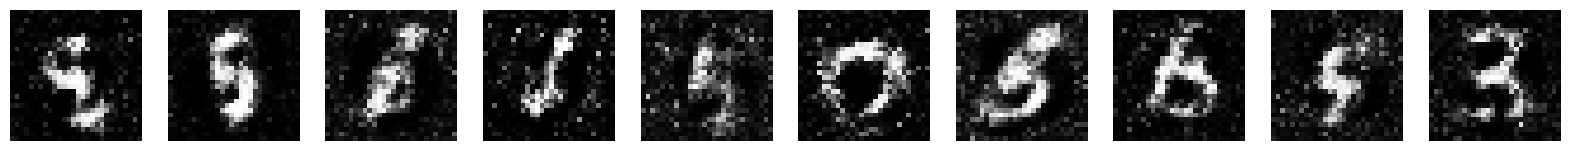

In [8]:
# Generate images after training
noise = np.random.normal(0, 1, (10, 100)) 
generated_images = generator_fc.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

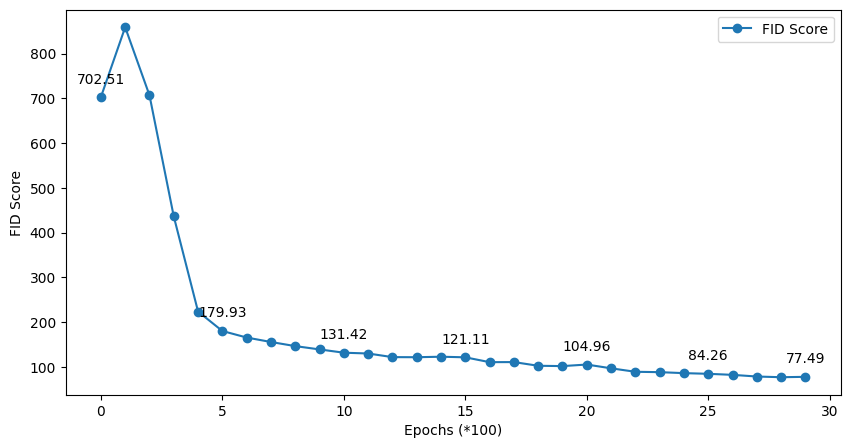

1/1 [==============================] - 0s 9ms/step


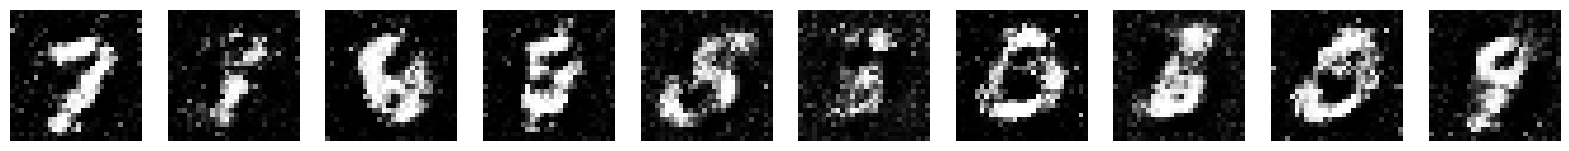

In [11]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores_fc, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores_fc):
    if i % 5 == 0 or i == 0 or i == len(fid_scores_fc) - 1:
        plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator_fc.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

## CNN

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from scipy.linalg import sqrtm
import numpy as np
import time
import matplotlib.pyplot as plt

np.random.seed(1000)
tf.random.set_seed(1000)

# input 100
# output 28*28*1

def build_generator():
    model = Sequential()
    
    # increase the dimension
    model.add(Dense(7*7*128, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(1, kernel_size=7, activation='tanh', padding='same'))

    return model

# input 28*28*1
# output 1

def build_discriminator():
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

# Load and preprocess the MNIST dataset
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)

# Calculate FID function
def calculate_fid(real_images, fake_images):
    act1 = real_images.reshape((real_images.shape[0], -1))
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    
    act2 = fake_images.reshape((fake_images.shape[0], -1))
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

def train_gan(epochs=1000, batch_size=64, p_epoch=100):
    generator = build_generator()
    discriminator = build_discriminator()

    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    # using half batches for the discriminator ensures balanced and efficient training, 
    # better memory management, and more stable training dynamics in GANs.
    half_batch = int(batch_size / 2)
    
    d_losses = []
    g_losses = []
    d_acc = []
    fid_scores = []  # List to store FID scores
    
    start_time = time.time()  # Record the start time

    for epoch in range(epochs):
        # Select a random half batch of real images
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        # Generate a half batch of new fake images
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        # Train the discriminator
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_y)

        # Record the losses
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_acc.append(d_loss[1] * 100)
        
        # Calculate FID every p_epoch epochs
        if epoch % p_epoch == 0:
            noise = np.random.normal(0, 1, (1000, 100))
            fake_images = generator.predict(noise)
            fid = calculate_fid(x_train[:1000], fake_images)
            fid_scores.append(fid)
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}] [FID: {fid}]")
    
    end_time = time.time()  # Record the end time
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    return generator, d_losses, g_losses, d_acc, fid_scores

In [13]:
generator_cnn = build_generator()
generator_cnn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 6272)              633472    
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_12 (Ba  (None, 7, 7, 128)         512       
 tchNormalization)                                               
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 14, 14, 128)      

In [14]:
discriminator_cnn = build_discriminator()
discriminator_cnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_9 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_4 (Flatten)         (None, 6272)             

In [15]:
generator_cnn, d_losses, g_losses, d_acc, fid_scores_cnn = train_gan(epochs=3000, batch_size=64, p_epoch=100)

32/32 [==============================] - 1s 16ms/step
0 [D loss: 0.7049608826637268, acc.: 18.75%] [G loss: 0.6856945753097534] [FID: 784.3744067186841]
32/32 [==============================] - 1s 16ms/step
100 [D loss: 0.7460590600967407, acc.: 21.875%] [G loss: 0.7147859930992126] [FID: 101.45044250593887]
32/32 [==============================] - 1s 16ms/step
200 [D loss: 0.7346457242965698, acc.: 28.125%] [G loss: 0.6962965726852417] [FID: 69.58345250661239]
32/32 [==============================] - 1s 17ms/step
300 [D loss: 0.7193491458892822, acc.: 34.375%] [G loss: 0.7261232137680054] [FID: 91.71945792303399]
1/1 [==============================] - 0s 103ms/step


32/32 [==============================] - 1s 16ms/step
400 [D loss: 0.7050629258155823, acc.: 48.4375%] [G loss: 0.7178875207901001] [FID: 95.18212446945816]
32/32 [==============================] - 1s 17ms/step
500 [D loss: 0.6948761940002441, acc.: 56.25%] [G loss: 0.7275567054748535] [FID: 70.09844605079782]
32/32 [==============================] - 1s 16ms/step
600 [D loss: 0.7096007168292999, acc.: 39.0625%] [G loss: 0.7326776385307312] [FID: 76.80460286051766]
1/1 [==============================] - 0s 21ms/step


32/32 [==============================] - 1s 16ms/step
700 [D loss: 0.6955478489398956, acc.: 50.0%] [G loss: 0.7328058481216431] [FID: 62.10881047172704]
32/32 [==============================] - 1s 16ms/step
800 [D loss: 0.6956726312637329, acc.: 48.4375%] [G loss: 0.7185229063034058] [FID: 60.29337109044906]
32/32 [==============================] - 1s 16ms/step
900 [D loss: 0.6636674404144287, acc.: 75.0%] [G loss: 0.8097221255302429] [FID: 75.76554128880127]
1/1 [==============================] - 0s 22ms/step


32/32 [==============================] - 1s 17ms/step
1000 [D loss: 0.6758991181850433, acc.: 65.625%] [G loss: 0.7533596754074097] [FID: 70.52549522160515]
32/32 [==============================] - 1s 16ms/step
1100 [D loss: 0.6963409185409546, acc.: 57.8125%] [G loss: 0.721436619758606] [FID: 58.97459417444013]
32/32 [==============================] - 1s 17ms/step
1200 [D loss: 0.6858553290367126, acc.: 51.5625%] [G loss: 0.7189850807189941] [FID: 137.88254921076788]
1/1 [==============================] - 0s 22ms/step


32/32 [==============================] - 1s 16ms/step
1300 [D loss: 0.7006879150867462, acc.: 45.3125%] [G loss: 0.7039763927459717] [FID: 61.63890707528428]
32/32 [==============================] - 1s 16ms/step
1400 [D loss: 0.6763737499713898, acc.: 60.9375%] [G loss: 0.7286795377731323] [FID: 44.71174491121337]
32/32 [==============================] - 1s 17ms/step
1500 [D loss: 0.7062934637069702, acc.: 45.3125%] [G loss: 0.7078278660774231] [FID: 51.04646281318753]
1/1 [==============================] - 0s 23ms/step


32/32 [==============================] - 1s 17ms/step
1600 [D loss: 0.6817135810852051, acc.: 59.375%] [G loss: 0.7211691737174988] [FID: 41.461487724722936]
32/32 [==============================] - 1s 18ms/step
1700 [D loss: 0.6924565434455872, acc.: 59.375%] [G loss: 0.73403400182724] [FID: 42.01749783333088]
32/32 [==============================] - 1s 17ms/step
1800 [D loss: 0.7019129991531372, acc.: 43.75%] [G loss: 0.714523196220398] [FID: 42.9510795310234]
1/1 [==============================] - 0s 21ms/step


32/32 [==============================] - 1s 17ms/step
1900 [D loss: 0.6846916675567627, acc.: 65.625%] [G loss: 0.7049077749252319] [FID: 40.36599359774675]
32/32 [==============================] - 1s 17ms/step
2000 [D loss: 0.6948732137680054, acc.: 51.5625%] [G loss: 0.7034674882888794] [FID: 44.78489043134582]
32/32 [==============================] - 1s 18ms/step
2100 [D loss: 0.6929572224617004, acc.: 56.25%] [G loss: 0.7141799926757812] [FID: 43.4670395209586]
1/1 [==============================] - 0s 21ms/step


32/32 [==============================] - 1s 18ms/step
2200 [D loss: 0.6901981234550476, acc.: 53.125%] [G loss: 0.713194727897644] [FID: 36.10370363411713]
32/32 [==============================] - 1s 18ms/step
2300 [D loss: 0.6879556477069855, acc.: 50.0%] [G loss: 0.7191686630249023] [FID: 39.769949890690455]
32/32 [==============================] - 1s 16ms/step
2400 [D loss: 0.6910420954227448, acc.: 54.6875%] [G loss: 0.7121223211288452] [FID: 39.42394550465361]
1/1 [==============================] - 0s 22ms/step


32/32 [==============================] - 1s 17ms/step
2500 [D loss: 0.6884793043136597, acc.: 50.0%] [G loss: 0.7019946575164795] [FID: 38.932086098615684]
32/32 [==============================] - 1s 17ms/step
2600 [D loss: 0.6964293420314789, acc.: 59.375%] [G loss: 0.7208725214004517] [FID: 38.845961642811915]
32/32 [==============================] - 1s 17ms/step
2700 [D loss: 0.6985907256603241, acc.: 46.875%] [G loss: 0.7093872427940369] [FID: 41.263026137800715]
1/1 [==============================] - 0s 23ms/step


32/32 [==============================] - 1s 17ms/step
2800 [D loss: 0.6870430111885071, acc.: 59.375%] [G loss: 0.6968997716903687] [FID: 35.18374492091541]
32/32 [==============================] - 1s 17ms/step
2900 [D loss: 0.6971621513366699, acc.: 51.5625%] [G loss: 0.7121918201446533] [FID: 44.943115692278376]
1/1 [==============================] - 0s 22ms/step
Total training time: 571.57 seconds


1/1 [==============================] - 0s 18ms/step


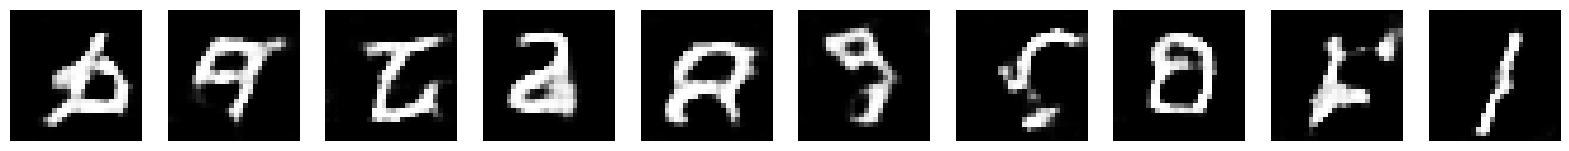

In [20]:
# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator_cnn.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

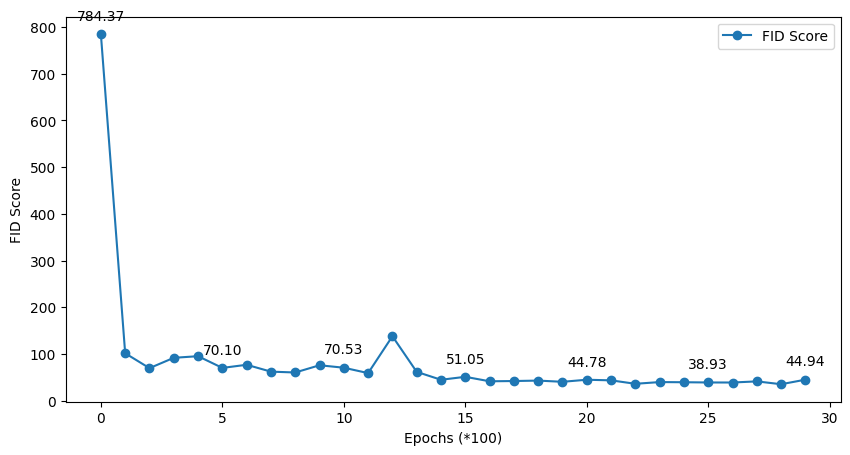

1/1 [==============================] - 0s 15ms/step


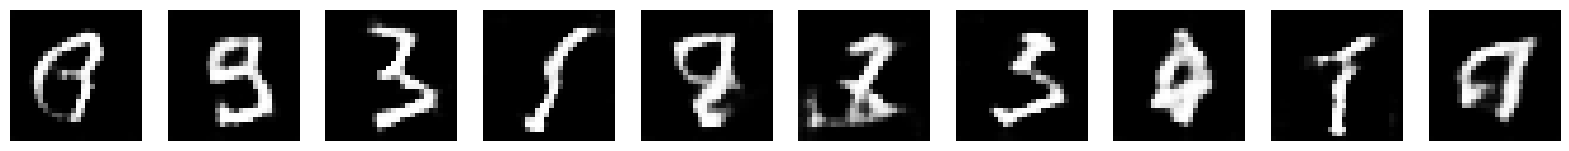

In [26]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores_cnn, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores_cnn):
    if i % 5 == 0 or i == 0 or i == len(fid_scores_fc) - 1:
        plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator_cnn.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

## CNN + FID + 1000 epochs

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from scipy.linalg import sqrtm
import numpy as np
import time
import matplotlib.pyplot as plt

np.random.seed(1000)
tf.random.set_seed(1000)

# input 100
# output 28*28*1

def build_generator():
    model = Sequential()
    
    # increase the dimension
    model.add(Dense(7*7*128, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(1, kernel_size=7, activation='tanh', padding='same'))

    return model

# input 28*28*1
# output 1

def build_discriminator():
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)

# 计算FID函数
def calculate_fid(real_images, fake_images):
    act1 = real_images.reshape((real_images.shape[0], -1))
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    
    act2 = fake_images.reshape((fake_images.shape[0], -1))
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

def train_gan(epochs=1000, batch_size=64, p_epoch=100):
    generator = build_generator()
    discriminator = build_discriminator()

    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    half_batch = int(batch_size / 2)
    
    d_losses = []
    g_losses = []
    d_acc = []
    fid_scores = []
    
    start_time = time.time()  # Record the start time

    for epoch in range(epochs):
        # Select a random half batch of real images
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        # Generate a half batch of new fake images
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        # Train the discriminator
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_y)

        # Record the losses
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_acc.append(d_loss[1] * 100)
        
        # Calculate FID every p_epoch epochs
        if epoch % p_epoch == 0:
            noise = np.random.normal(0, 1, (1000, 100))
            fake_images = generator.predict(noise)
            fid = calculate_fid(x_train[:1000], fake_images)
            fid_scores.append(fid)
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}] [FID: {fid}]")

    end_time = time.time()  # Record the end time
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    return generator, d_losses, g_losses, d_acc, fid_scores



In [2]:
# Training the GAN with FID calculation
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000, batch_size=64, p_epoch=100)

32/32 [==============================] - 0s 13ms/step
0 [D loss: 0.7120801508426666, acc.: 10.9375%] [G loss: 0.69498610496521] [FID: 698.394097517572]
32/32 [==============================] - 1s 17ms/step
100 [D loss: 0.6781625151634216, acc.: 60.9375%] [G loss: 0.7515887022018433] [FID: 183.89600563078298]
32/32 [==============================] - 1s 17ms/step
200 [D loss: 0.6800318360328674, acc.: 53.125%] [G loss: 0.6914176344871521] [FID: 126.52763151953792]
32/32 [==============================] - 1s 19ms/step
300 [D loss: 0.699704647064209, acc.: 42.1875%] [G loss: 0.7203076481819153] [FID: 106.1802499518399]
1/1 [==============================] - 0s 92ms/step


32/32 [==============================] - 1s 19ms/step
400 [D loss: 0.7059690952301025, acc.: 40.625%] [G loss: 0.7185416221618652] [FID: 96.4136801373894]
32/32 [==============================] - 1s 20ms/step
500 [D loss: 0.7103128135204315, acc.: 39.0625%] [G loss: 0.7024992108345032] [FID: 95.76550782263922]
1/1 [==============================] - 0s 23ms/step


KeyboardInterrupt: 

In [ ]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

# 标注每个数据点
for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [51]:
# Training the GAN with FID calculation
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000, batch_size=64, p_epoch=100)

32/32 [==============================] - 1s 17ms/step
0 [D loss: 0.651642769575119, acc.: 46.875%] [G loss: 0.6357065439224243] [FID: 783.3447426356856]
32/32 [==============================] - 1s 16ms/step
100 [D loss: 0.7639965415000916, acc.: 20.3125%] [G loss: 0.7167040109634399] [FID: 108.09040447009798]
32/32 [==============================] - 0s 15ms/step
200 [D loss: 0.7137995362281799, acc.: 31.25%] [G loss: 0.7390925288200378] [FID: 88.10082130499018]
32/32 [==============================] - 0s 15ms/step
300 [D loss: 0.7033654749393463, acc.: 43.75%] [G loss: 0.7096824645996094] [FID: 70.40110535112252]
1/1 [==============================] - 0s 67ms/step


32/32 [==============================] - 0s 15ms/step
400 [D loss: 0.7163931131362915, acc.: 42.1875%] [G loss: 0.7107174396514893] [FID: 69.49373766202878]
32/32 [==============================] - 0s 14ms/step
500 [D loss: 0.7022398114204407, acc.: 51.5625%] [G loss: 0.7042266130447388] [FID: 69.7960112232569]
32/32 [==============================] - 0s 14ms/step
600 [D loss: 0.7078427374362946, acc.: 40.625%] [G loss: 0.7131937146186829] [FID: 86.85671295201472]
1/1 [==============================] - 0s 20ms/step


32/32 [==============================] - 0s 14ms/step
700 [D loss: 0.7013041079044342, acc.: 37.5%] [G loss: 0.712319552898407] [FID: 83.7726491793058]
32/32 [==============================] - 0s 14ms/step
800 [D loss: 0.7068849205970764, acc.: 37.5%] [G loss: 0.7065004706382751] [FID: 71.95999359681804]
32/32 [==============================] - 0s 15ms/step
900 [D loss: 0.6976528763771057, acc.: 50.0%] [G loss: 0.7213351726531982] [FID: 69.59672342078112]
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 20ms/step
Total training time: 183.75 seconds


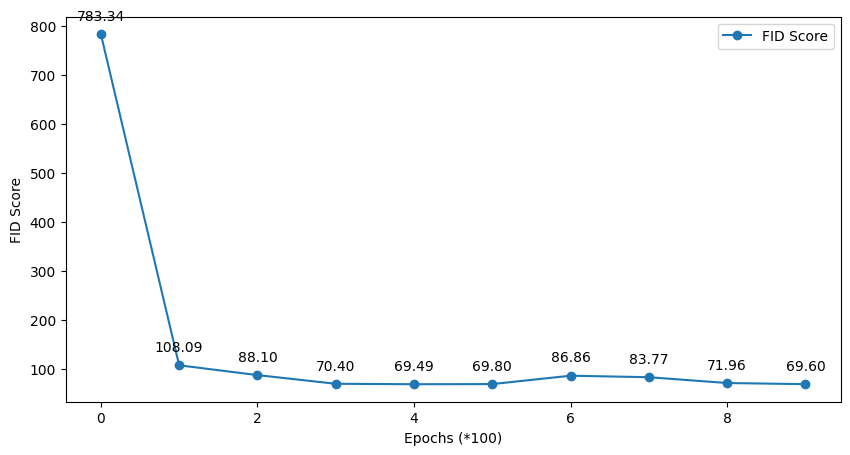

1/1 [==============================] - 0s 15ms/step


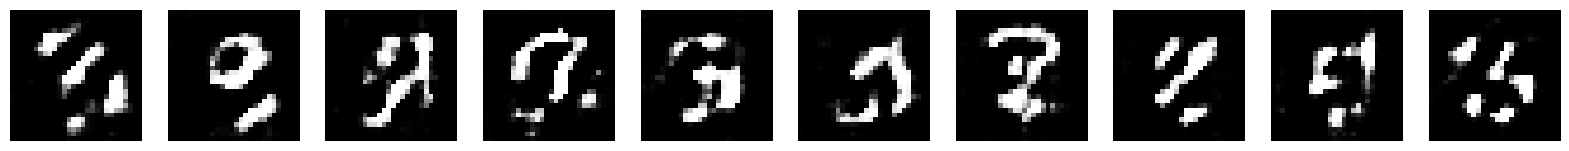

In [52]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

# 标注每个数据点
for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [53]:
# Training the GAN with FID calculation
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000, batch_size=64, p_epoch=100)

32/32 [==============================] - 1s 15ms/step
0 [D loss: 0.679859846830368, acc.: 51.5625%] [G loss: 0.671293318271637] [FID: 647.4007539589205]
32/32 [==============================] - 0s 14ms/step
100 [D loss: 0.608392059803009, acc.: 65.625%] [G loss: 1.0338503122329712] [FID: 203.48273193191676]
32/32 [==============================] - 1s 16ms/step
200 [D loss: 0.6513369977474213, acc.: 67.1875%] [G loss: 0.7406504154205322] [FID: 118.62812536374399]
32/32 [==============================] - 0s 14ms/step
300 [D loss: 0.706777036190033, acc.: 50.0%] [G loss: 0.7017875909805298] [FID: 87.97252933938442]
1/1 [==============================] - 0s 87ms/step


32/32 [==============================] - 0s 14ms/step
400 [D loss: 0.6934390366077423, acc.: 50.0%] [G loss: 0.7233855128288269] [FID: 89.51842168914916]
32/32 [==============================] - 0s 14ms/step
500 [D loss: 0.7057810723781586, acc.: 46.875%] [G loss: 0.7043863534927368] [FID: 75.20828773467365]
32/32 [==============================] - 0s 15ms/step
600 [D loss: 0.7014626860618591, acc.: 39.0625%] [G loss: 0.7098401188850403] [FID: 107.46871859813504]
1/1 [==============================] - 0s 23ms/step


32/32 [==============================] - 0s 14ms/step
700 [D loss: 0.6966422200202942, acc.: 42.1875%] [G loss: 0.7262232303619385] [FID: 83.44231546152558]
32/32 [==============================] - 0s 14ms/step
800 [D loss: 0.6860724985599518, acc.: 54.6875%] [G loss: 0.7186712026596069] [FID: 64.46511340579977]
32/32 [==============================] - 0s 14ms/step
900 [D loss: 0.6965168714523315, acc.: 48.4375%] [G loss: 0.7142263054847717] [FID: 60.25948417407973]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step
Total training time: 179.84 seconds


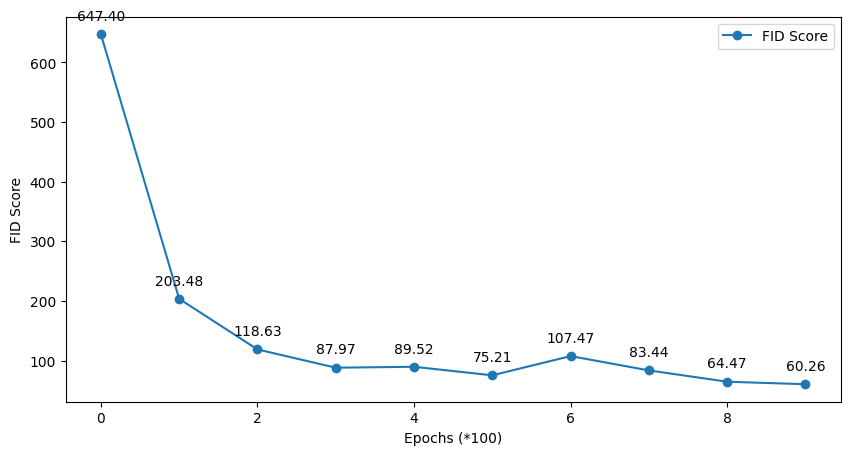

1/1 [==============================] - 0s 17ms/step


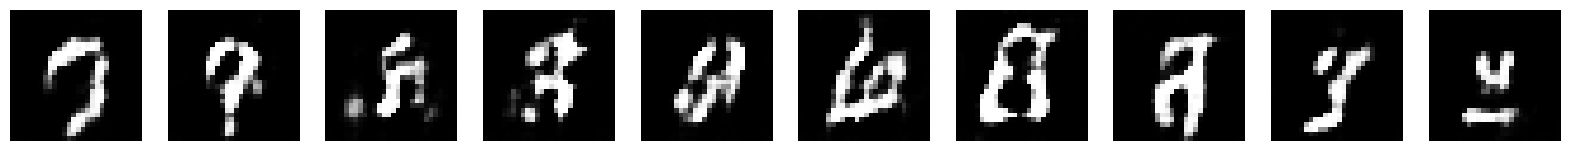

In [54]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

# 标注每个数据点
for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

## CNN + FID + Data augmentation + 1000 epochs

In [64]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from scipy.linalg import sqrtm
import numpy as np
import time
import matplotlib.pyplot as plt

np.random.seed(1000)
tf.random.set_seed(1000)

# input 100
# output 28*28*1

def build_generator():
    model = Sequential()
    
    # increase the dimension
    model.add(Dense(7*7*128, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(1, kernel_size=7, activation='tanh', padding='same'))

    return model

# input 28*28*1
# output 1

def build_discriminator():
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)

# 定义数据增强
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# 计算FID函数
def calculate_fid(real_images, fake_images):
    act1 = real_images.reshape((real_images.shape[0], -1))
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    
    act2 = fake_images.reshape((fake_images.shape[0], -1))
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

def train_gan(epochs=1000, batch_size=64, p_epoch=100):
    generator = build_generator()
    discriminator = build_discriminator()

    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    half_batch = int(batch_size / 2)
    
    d_losses = []
    g_losses = []
    d_acc = []
    fid_scores = []
    
    start_time = time.time()  # Record the start time

    for epoch in range(epochs):
        # Select a random half batch of real images
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        # 应用数据增强
        real_images_augmented = next(datagen.flow(real_images, batch_size=half_batch))

        # Generate a half batch of new fake images
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        # Train the discriminator
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_images_augmented, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_y)

        # Record the losses
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_acc.append(d_loss[1] * 100)
        
        # Calculate FID every p_epoch epochs
        if epoch % p_epoch == 0:
            noise = np.random.normal(0, 1, (1000, 100))
            fake_images = generator.predict(noise)
            fid = calculate_fid(x_train[:1000], fake_images)
            fid_scores.append(fid)
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}] [FID: {fid}]")

    end_time = time.time()  # Record the end time
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    return generator, d_losses, g_losses, d_acc, fid_scores

# Training the GAN with data augmentation and FID calculation
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000, batch_size=64, p_epoch=100)

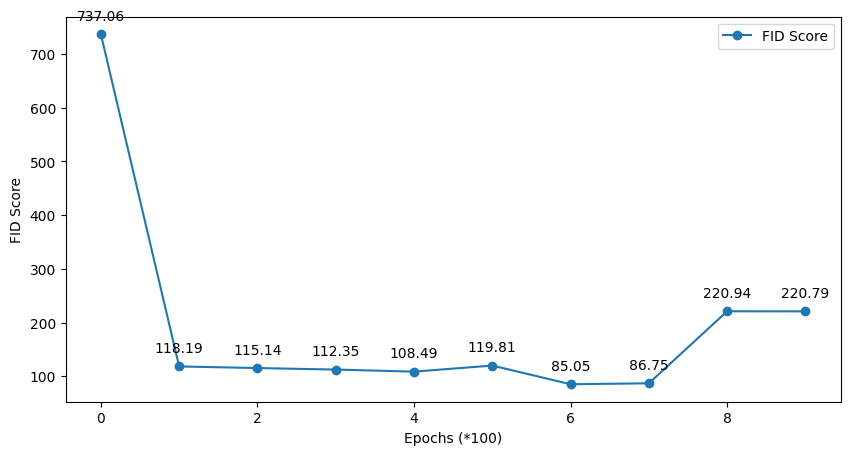

1/1 [==============================] - 0s 18ms/step


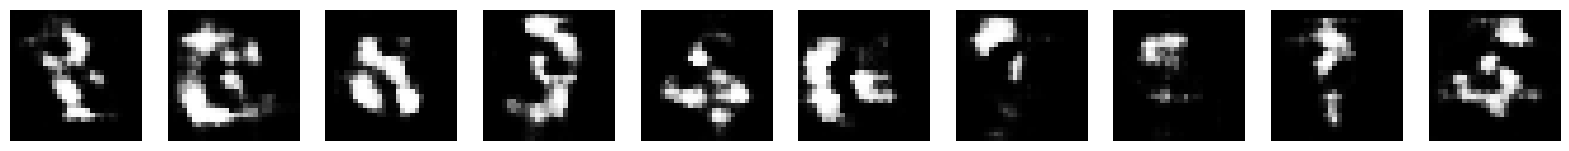

In [46]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [55]:
# Training the GAN with data augmentation and FID calculation
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000, batch_size=64, p_epoch=100)

32/32 [==============================] - 1s 15ms/step
0 [D loss: 0.7124409675598145, acc.: 12.5%] [G loss: 0.6784403920173645] [FID: 670.3244982267839]
32/32 [==============================] - 1s 16ms/step
100 [D loss: 0.6239662766456604, acc.: 68.75%] [G loss: 0.9494784474372864] [FID: 190.32971659968914]
32/32 [==============================] - 0s 15ms/step
200 [D loss: 0.7206841111183167, acc.: 35.9375%] [G loss: 0.7264549732208252] [FID: 99.2870003071689]
32/32 [==============================] - 0s 14ms/step
300 [D loss: 0.6978961527347565, acc.: 54.6875%] [G loss: 0.6971566677093506] [FID: 85.73610638825792]
1/1 [==============================] - 0s 51ms/step


32/32 [==============================] - 0s 15ms/step
400 [D loss: 0.705868661403656, acc.: 45.3125%] [G loss: 0.6985557079315186] [FID: 80.92510984821331]
32/32 [==============================] - 0s 14ms/step
500 [D loss: 0.699536919593811, acc.: 48.4375%] [G loss: 0.7100173830986023] [FID: 75.07406255191837]
32/32 [==============================] - 0s 14ms/step
600 [D loss: 0.6969319581985474, acc.: 50.0%] [G loss: 0.7230134606361389] [FID: 70.04348479384787]
1/1 [==============================] - 0s 20ms/step


32/32 [==============================] - 0s 14ms/step
700 [D loss: 0.6884692907333374, acc.: 56.25%] [G loss: 0.7186742424964905] [FID: 68.01442080531109]
32/32 [==============================] - 0s 15ms/step
800 [D loss: 0.6895850002765656, acc.: 51.5625%] [G loss: 0.7185992002487183] [FID: 66.53127234403428]
32/32 [==============================] - 0s 15ms/step
900 [D loss: 0.6977779865264893, acc.: 51.5625%] [G loss: 0.7144163250923157] [FID: 76.3348877412821]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step
Total training time: 181.34 seconds


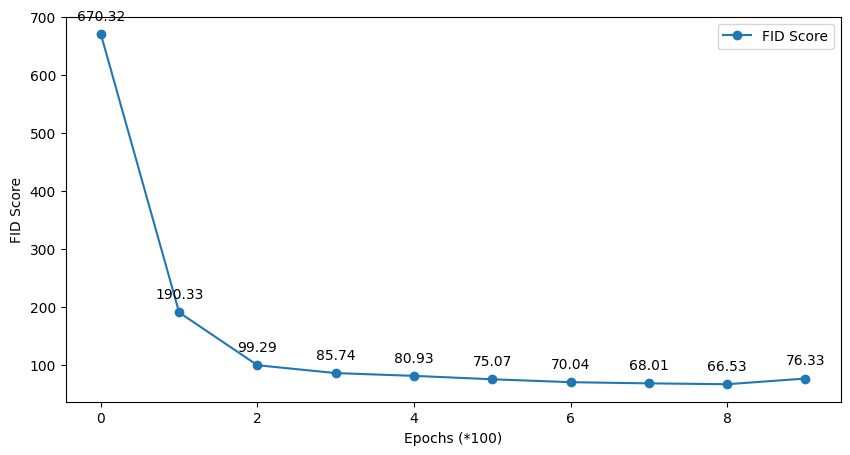

1/1 [==============================] - 0s 20ms/step


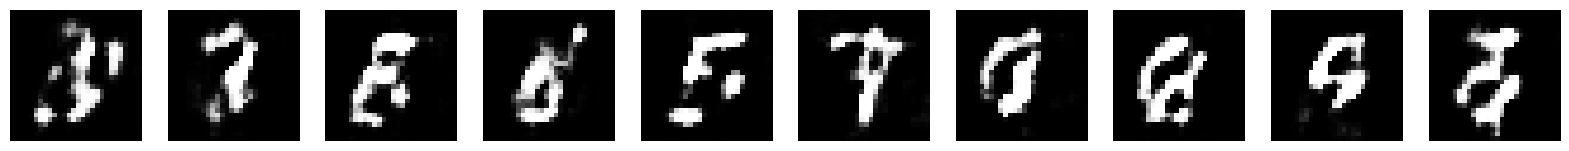

In [56]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [57]:
# Training the GAN with data augmentation and FID calculation
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000, batch_size=64, p_epoch=100)

32/32 [==============================] - 1s 16ms/step
0 [D loss: 0.6891357004642487, acc.: 34.375%] [G loss: 0.6431775093078613] [FID: 681.7269893832463]
32/32 [==============================] - 1s 18ms/step
100 [D loss: 0.5883301794528961, acc.: 76.5625%] [G loss: 0.9183851480484009] [FID: 200.8622322347569]
32/32 [==============================] - 1s 16ms/step
200 [D loss: 0.7126651406288147, acc.: 45.3125%] [G loss: 0.7186173796653748] [FID: 99.00246254599497]
32/32 [==============================] - 0s 14ms/step
300 [D loss: 0.6966190338134766, acc.: 53.125%] [G loss: 0.7173454165458679] [FID: 85.1942696754533]
1/1 [==============================] - 0s 76ms/step


32/32 [==============================] - 0s 15ms/step
400 [D loss: 0.6950945854187012, acc.: 54.6875%] [G loss: 0.71588534116745] [FID: 81.57830927642104]
32/32 [==============================] - 1s 17ms/step
500 [D loss: 0.7046069204807281, acc.: 45.3125%] [G loss: 0.719692587852478] [FID: 75.17863346477749]
32/32 [==============================] - 1s 16ms/step
600 [D loss: 0.6876976788043976, acc.: 59.375%] [G loss: 0.715530514717102] [FID: 66.87377033027613]
1/1 [==============================] - 0s 24ms/step


32/32 [==============================] - 1s 16ms/step
700 [D loss: 0.6959008574485779, acc.: 53.125%] [G loss: 0.7337952852249146] [FID: 65.00692539066777]
32/32 [==============================] - 0s 15ms/step
800 [D loss: 0.6885123550891876, acc.: 51.5625%] [G loss: 0.7259398102760315] [FID: 60.931365779506166]
32/32 [==============================] - 1s 16ms/step
900 [D loss: 0.6887741684913635, acc.: 54.6875%] [G loss: 0.7197819948196411] [FID: 59.49150459175341]
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step
Total training time: 187.09 seconds


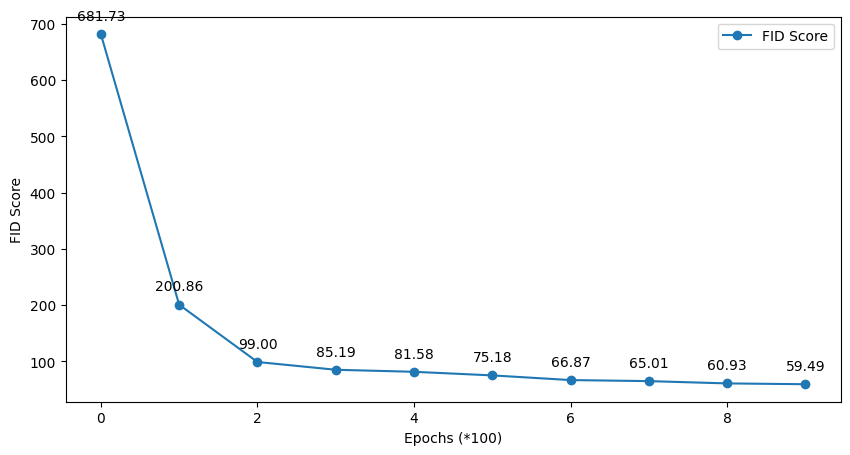

1/1 [==============================] - 0s 19ms/step


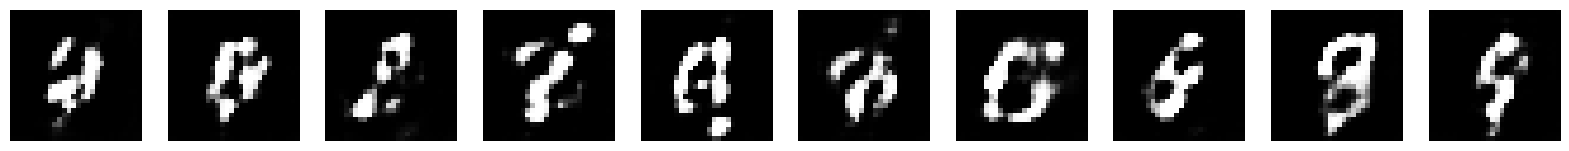

In [58]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

## CNN + FID + Data augmentation + rotation + width and height shift + 1000 epochs

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from scipy.linalg import sqrtm
import numpy as np
import time
import matplotlib.pyplot as plt

np.random.seed(1000)
tf.random.set_seed(1000)

# input 100
# output 28*28*1

def build_generator():
    model = Sequential()
    
    # increase the dimension
    model.add(Dense(7*7*128, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(1, kernel_size=7, activation='tanh', padding='same'))

    return model

# input 28*28*1
# output 1

def build_discriminator():
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)

# 定义数据增强
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

# 计算FID函数
def calculate_fid(real_images, fake_images):
    act1 = real_images.reshape((real_images.shape[0], -1))
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    
    act2 = fake_images.reshape((fake_images.shape[0], -1))
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

def train_gan(epochs=1000, batch_size=64, p_epoch=100):
    generator = build_generator()
    discriminator = build_discriminator()

    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    half_batch = int(batch_size / 2)
    
    d_losses = []
    g_losses = []
    d_acc = []
    fid_scores = []
    
    start_time = time.time()  # Record the start time

    for epoch in range(epochs):
        # Select a random half batch of real images
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        # 应用数据增强
        real_images_augmented = next(datagen.flow(real_images, batch_size=half_batch))

        # Generate a half batch of new fake images
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        # Train the discriminator
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_images_augmented, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_y)

        # Record the losses
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_acc.append(d_loss[1] * 100)
        
        # Calculate FID every p_epoch epochs
        if epoch % p_epoch == 0:
            noise = np.random.normal(0, 1, (1000, 100))
            fake_images = generator.predict(noise)
            fid = calculate_fid(x_train[:1000], fake_images)
            fid_scores.append(fid)
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}] [FID: {fid}]")

    end_time = time.time()  # Record the end time
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    return generator, d_losses, g_losses, d_acc, fid_scores

# Training the GAN with data augmentation and FID calculation
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000, batch_size=64, p_epoch=100)

32/32 [==============================] - 0s 13ms/step
0 [D loss: 0.698507159948349, acc.: 23.4375%] [G loss: 0.6816770434379578] [FID: 729.7493167043492]
32/32 [==============================] - 0s 14ms/step
100 [D loss: 0.7636377215385437, acc.: 21.875%] [G loss: 0.7379094362258911] [FID: 126.42559930896076]
1/1 [==============================] - 0s 21ms/step


32/32 [==============================] - 0s 15ms/step
200 [D loss: 0.7225075662136078, acc.: 34.375%] [G loss: 0.7133181095123291] [FID: 107.66430073491838]
32/32 [==============================] - 1s 16ms/step
300 [D loss: 0.7093331515789032, acc.: 32.8125%] [G loss: 0.7296973466873169] [FID: 65.96018356742911]
1/1 [==============================] - 0s 85ms/step


32/32 [==============================] - 1s 17ms/step
400 [D loss: 0.721563458442688, acc.: 34.375%] [G loss: 0.7144055962562561] [FID: 74.26207725639175]
1/1 [==============================] - 0s 23ms/step


32/32 [==============================] - 1s 16ms/step
500 [D loss: 0.7062658369541168, acc.: 40.625%] [G loss: 0.7246419191360474] [FID: 80.05767425693008]
32/32 [==============================] - 1s 18ms/step
600 [D loss: 0.6948076784610748, acc.: 53.125%] [G loss: 0.7211827039718628] [FID: 96.4043288879932]
1/1 [==============================] - 0s 23ms/step


32/32 [==============================] - 1s 17ms/step
700 [D loss: 0.6977234482765198, acc.: 45.3125%] [G loss: 0.747916579246521] [FID: 144.43246622112912]
1/1 [==============================] - 0s 23ms/step


32/32 [==============================] - 1s 16ms/step
800 [D loss: 0.6964339017868042, acc.: 37.5%] [G loss: 0.7190310955047607] [FID: 73.97409440692735]
32/32 [==============================] - 1s 18ms/step
900 [D loss: 0.7040747702121735, acc.: 35.9375%] [G loss: 0.7273310422897339] [FID: 66.04309585892209]
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step
Total training time: 195.50 seconds


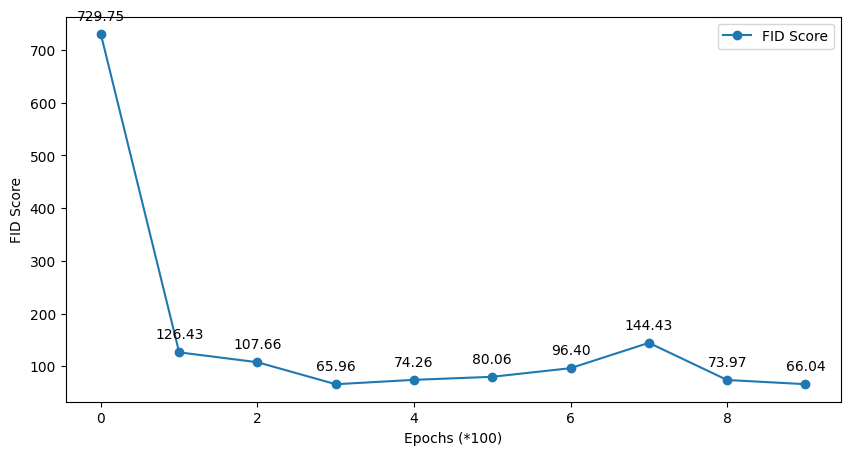

1/1 [==============================] - 0s 18ms/step


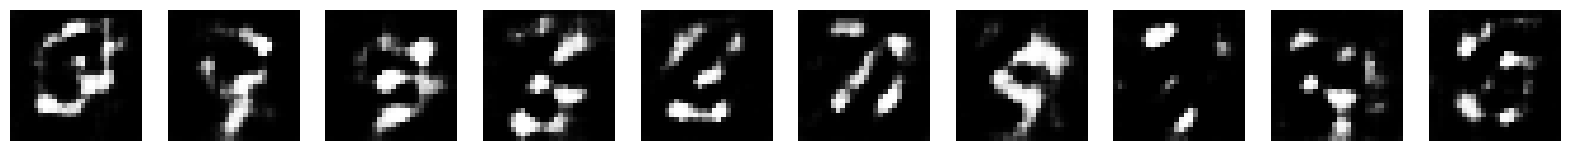

In [2]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [3]:
# Training the GAN with data augmentation and FID calculation
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000, batch_size=64, p_epoch=100)

32/32 [==============================] - 1s 17ms/step
0 [D loss: 0.7218132317066193, acc.: 21.875%] [G loss: 0.7028191089630127] [FID: 761.1968149529275]
32/32 [==============================] - 1s 19ms/step
100 [D loss: 0.7533228099346161, acc.: 37.5%] [G loss: 0.7291623950004578] [FID: 110.60500624586555]
1/1 [==============================] - 0s 22ms/step


32/32 [==============================] - 1s 18ms/step
200 [D loss: 0.7121246755123138, acc.: 43.75%] [G loss: 0.716646671295166] [FID: 97.7160602106968]
32/32 [==============================] - 1s 17ms/step
300 [D loss: 0.7084730267524719, acc.: 42.1875%] [G loss: 0.7325975894927979] [FID: 73.84215557075454]
1/1 [==============================] - 0s 90ms/step


32/32 [==============================] - 1s 19ms/step
400 [D loss: 0.7151955366134644, acc.: 35.9375%] [G loss: 0.7304448485374451] [FID: 72.62517942579558]
1/1 [==============================] - 0s 26ms/step


32/32 [==============================] - 1s 18ms/step
500 [D loss: 0.6998876929283142, acc.: 51.5625%] [G loss: 0.7168172597885132] [FID: 78.49466798677814]
32/32 [==============================] - 1s 19ms/step
600 [D loss: 0.7156141400337219, acc.: 40.625%] [G loss: 0.7112210988998413] [FID: 81.31423908817769]
1/1 [==============================] - 0s 25ms/step


32/32 [==============================] - 1s 19ms/step
700 [D loss: 0.6919601261615753, acc.: 48.4375%] [G loss: 0.709464430809021] [FID: 91.32413534752658]
1/1 [==============================] - 0s 26ms/step


32/32 [==============================] - 1s 18ms/step
800 [D loss: 0.6889635324478149, acc.: 54.6875%] [G loss: 0.7261846661567688] [FID: 77.31478516091738]
32/32 [==============================] - 1s 19ms/step
900 [D loss: 0.691981315612793, acc.: 50.0%] [G loss: 0.712053656578064] [FID: 77.55236880958354]
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step
Total training time: 202.85 seconds


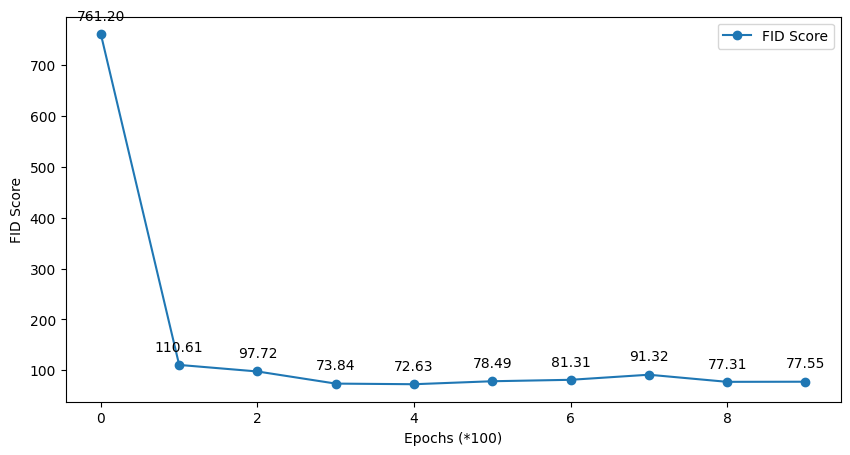

1/1 [==============================] - 0s 19ms/step


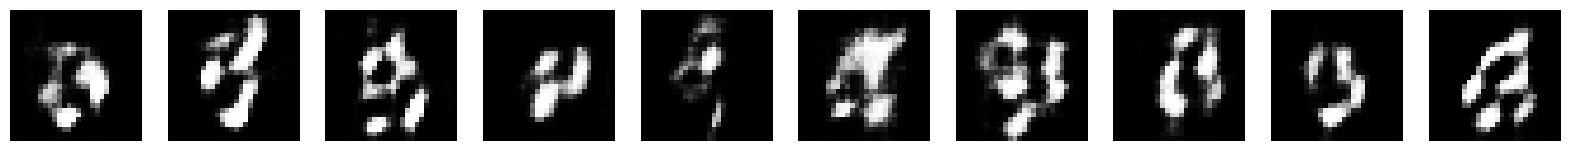

In [4]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [5]:
# Training the GAN with data augmentation and FID calculation
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000, batch_size=64, p_epoch=100)

32/32 [==============================] - 1s 19ms/step
0 [D loss: 0.7119300961494446, acc.: 21.875%] [G loss: 0.6948667764663696] [FID: 759.5116663826573]
32/32 [==============================] - 1s 19ms/step
100 [D loss: 0.7546945214271545, acc.: 28.125%] [G loss: 0.7435070276260376] [FID: 114.66903284134398]
1/1 [==============================] - 0s 29ms/step


32/32 [==============================] - 1s 20ms/step
200 [D loss: 0.7143585383892059, acc.: 40.625%] [G loss: 0.6815544366836548] [FID: 111.41152566295003]
32/32 [==============================] - 1s 17ms/step
300 [D loss: 0.7070631980895996, acc.: 50.0%] [G loss: 0.7153950333595276] [FID: 78.33512878459872]
1/1 [==============================] - 0s 75ms/step


32/32 [==============================] - 1s 17ms/step
400 [D loss: 0.7168200016021729, acc.: 37.5%] [G loss: 0.7232089042663574] [FID: 81.94266056585357]
1/1 [==============================] - 0s 25ms/step


32/32 [==============================] - 1s 18ms/step
500 [D loss: 0.7010562121868134, acc.: 42.1875%] [G loss: 0.7333319187164307] [FID: 88.59337464725999]
32/32 [==============================] - 1s 18ms/step
600 [D loss: 0.7039523720741272, acc.: 48.4375%] [G loss: 0.7269353866577148] [FID: 110.94550024227848]
1/1 [==============================] - 0s 24ms/step


32/32 [==============================] - 1s 16ms/step
700 [D loss: 0.6941700279712677, acc.: 54.6875%] [G loss: 0.7259384989738464] [FID: 68.32381175262275]
1/1 [==============================] - 0s 28ms/step


32/32 [==============================] - 1s 19ms/step
800 [D loss: 0.6982334852218628, acc.: 50.0%] [G loss: 0.7353463768959045] [FID: 67.1946937347554]
32/32 [==============================] - 1s 17ms/step
900 [D loss: 0.689428985118866, acc.: 46.875%] [G loss: 0.7196793556213379] [FID: 65.21646871636595]
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step
Total training time: 205.26 seconds


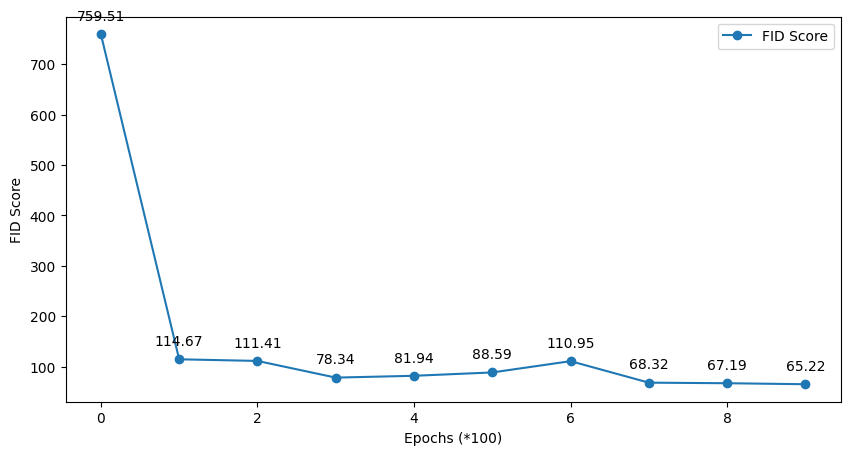

1/1 [==============================] - 0s 21ms/step


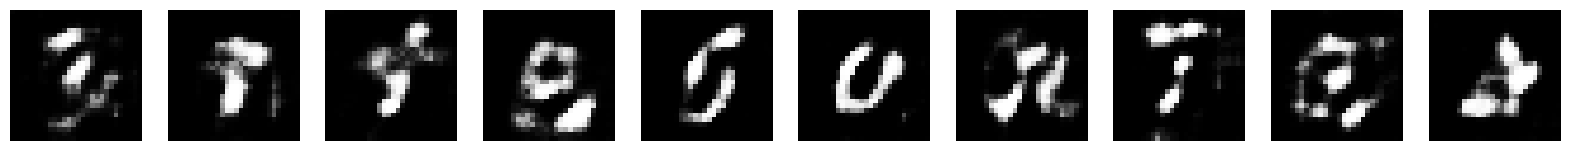

In [6]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

## CNN + FID + Data augmentation + width and height shift + 1000 epochs

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from scipy.linalg import sqrtm
import numpy as np
import time
import matplotlib.pyplot as plt

np.random.seed(1000)
tf.random.set_seed(1000)

# input 100
# output 28*28*1

def build_generator():
    model = Sequential()
    
    # increase the dimension
    model.add(Dense(7*7*128, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(1, kernel_size=7, activation='tanh', padding='same'))

    return model

# input 28*28*1
# output 1

def build_discriminator():
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)

# 定义数据增强
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.05,
    height_shift_range=0.05,
)

# 计算FID函数
def calculate_fid(real_images, fake_images):
    act1 = real_images.reshape((real_images.shape[0], -1))
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    
    act2 = fake_images.reshape((fake_images.shape[0], -1))
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

def train_gan(epochs=1000, batch_size=64, p_epoch=100):
    generator = build_generator()
    discriminator = build_discriminator()

    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    half_batch = int(batch_size / 2)
    
    d_losses = []
    g_losses = []
    d_acc = []
    fid_scores = []
    
    start_time = time.time()  # Record the start time

    for epoch in range(epochs):
        # Select a random half batch of real images
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        # 应用数据增强
        real_images_augmented = next(datagen.flow(real_images, batch_size=half_batch))

        # Generate a half batch of new fake images
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        # Train the discriminator
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_images_augmented, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_y)

        # Record the losses
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_acc.append(d_loss[1] * 100)
        
        # Calculate FID every p_epoch epochs
        if epoch % p_epoch == 0:
            noise = np.random.normal(0, 1, (1000, 100))
            fake_images = generator.predict(noise)
            fid = calculate_fid(x_train[:1000], fake_images)
            fid_scores.append(fid)
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}] [FID: {fid}]")

    end_time = time.time()  # Record the end time
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    return generator, d_losses, g_losses, d_acc, fid_scores

# Training the GAN with data augmentation and FID calculation
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000, batch_size=64, p_epoch=100)

32/32 [==============================] - 1s 19ms/step
0 [D loss: 0.7307251393795013, acc.: 3.125%] [G loss: 0.6836252212524414] [FID: 750.5363008100408]
32/32 [==============================] - 1s 17ms/step
100 [D loss: 0.8512349128723145, acc.: 28.125%] [G loss: 0.5523443222045898] [FID: 173.3591402530148]
1/1 [==============================] - 0s 25ms/step


32/32 [==============================] - 1s 17ms/step
200 [D loss: 0.734257698059082, acc.: 31.25%] [G loss: 0.7198363542556763] [FID: 88.92443983864068]
32/32 [==============================] - 1s 16ms/step
300 [D loss: 0.7058956325054169, acc.: 45.3125%] [G loss: 0.7249873280525208] [FID: 76.10391322078749]
1/1 [==============================] - 0s 94ms/step


32/32 [==============================] - 1s 17ms/step
400 [D loss: 0.7178823053836823, acc.: 34.375%] [G loss: 0.7092859745025635] [FID: 88.82847216773487]
1/1 [==============================] - 0s 24ms/step


32/32 [==============================] - 1s 18ms/step
500 [D loss: 0.6855812966823578, acc.: 53.125%] [G loss: 0.7125746607780457] [FID: 72.95494706705543]
32/32 [==============================] - 1s 16ms/step
600 [D loss: 0.6909659802913666, acc.: 50.0%] [G loss: 0.6947287321090698] [FID: 89.93033092878028]
1/1 [==============================] - 0s 24ms/step


32/32 [==============================] - 1s 18ms/step
700 [D loss: 0.6860568225383759, acc.: 56.25%] [G loss: 0.6982108354568481] [FID: 82.97696881635673]
1/1 [==============================] - 0s 25ms/step


32/32 [==============================] - 1s 19ms/step
800 [D loss: 0.6899950504302979, acc.: 56.25%] [G loss: 0.7160724401473999] [FID: 66.24825140870051]
32/32 [==============================] - 1s 19ms/step
900 [D loss: 0.6981704831123352, acc.: 50.0%] [G loss: 0.7069687247276306] [FID: 64.73634104879726]
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 21ms/step
Total training time: 203.37 seconds


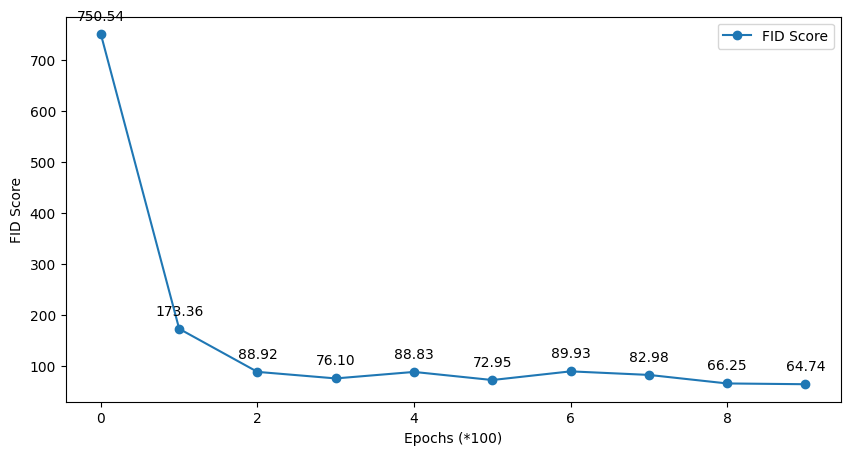

1/1 [==============================] - 0s 17ms/step


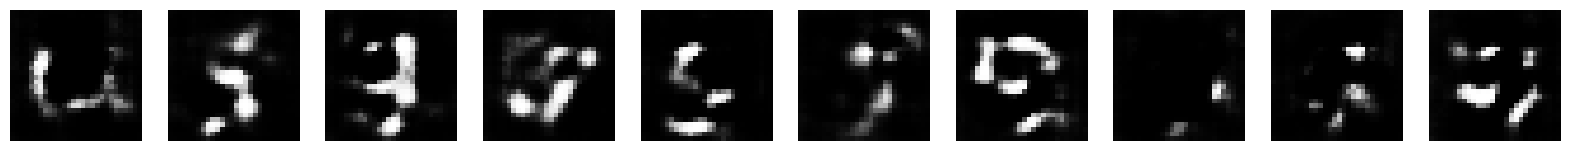

In [8]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [9]:
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000, batch_size=64, p_epoch=100)

32/32 [==============================] - 1s 16ms/step
0 [D loss: 0.7148058414459229, acc.: 17.1875%] [G loss: 0.680016815662384] [FID: 713.555550629054]
32/32 [==============================] - 0s 15ms/step
100 [D loss: 0.7183161973953247, acc.: 46.875%] [G loss: 0.7014887928962708] [FID: 116.52557728446169]
1/1 [==============================] - 0s 20ms/step


32/32 [==============================] - 0s 14ms/step
200 [D loss: 0.7235690057277679, acc.: 37.5%] [G loss: 0.737293541431427] [FID: 86.9542956589596]
32/32 [==============================] - 0s 15ms/step
300 [D loss: 0.7266069054603577, acc.: 28.125%] [G loss: 0.721429705619812] [FID: 70.79832108200273]
1/1 [==============================] - 0s 99ms/step


32/32 [==============================] - 1s 16ms/step
400 [D loss: 0.7051571905612946, acc.: 37.5%] [G loss: 0.7258164286613464] [FID: 75.29752847178227]
1/1 [==============================] - 0s 23ms/step


32/32 [==============================] - 1s 17ms/step
500 [D loss: 0.702573150396347, acc.: 39.0625%] [G loss: 0.7157526612281799] [FID: 67.26092563746798]
32/32 [==============================] - 1s 16ms/step
600 [D loss: 0.7125677764415741, acc.: 35.9375%] [G loss: 0.7148258686065674] [FID: 70.49550341647937]
1/1 [==============================] - 0s 22ms/step


32/32 [==============================] - 0s 14ms/step
700 [D loss: 0.6874459087848663, acc.: 59.375%] [G loss: 0.7516225576400757] [FID: 94.12329193346633]
1/1 [==============================] - 0s 23ms/step


32/32 [==============================] - 0s 15ms/step
800 [D loss: 0.6844115555286407, acc.: 60.9375%] [G loss: 0.7234612703323364] [FID: 64.4485654292316]
32/32 [==============================] - 0s 15ms/step
900 [D loss: 0.6922378540039062, acc.: 51.5625%] [G loss: 0.7201167345046997] [FID: 61.26198273169029]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step
Total training time: 183.23 seconds


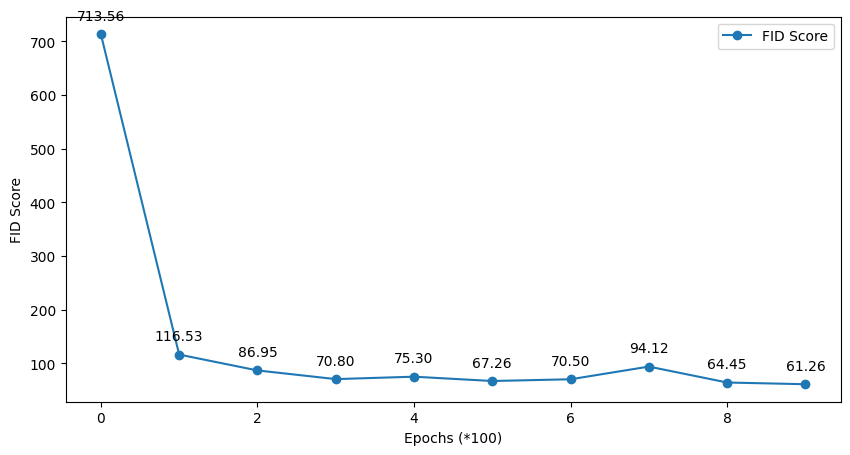

1/1 [==============================] - 0s 18ms/step


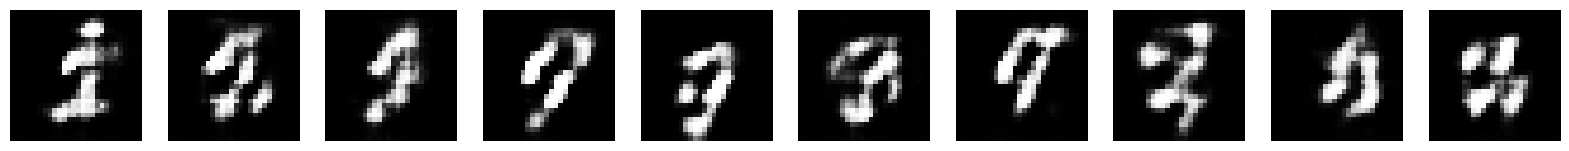

In [10]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [13]:
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000, batch_size=64, p_epoch=100)

32/32 [==============================] - 0s 13ms/step
0 [D loss: 0.7208089828491211, acc.: 42.1875%] [G loss: 0.713902473449707] [FID: 662.5503915022246]
32/32 [==============================] - 1s 16ms/step
100 [D loss: 0.5127890855073929, acc.: 82.8125%] [G loss: 0.9869334697723389] [FID: 202.9201001910287]
1/1 [==============================] - 0s 26ms/step


32/32 [==============================] - 1s 16ms/step
200 [D loss: 0.6599104702472687, acc.: 67.1875%] [G loss: 0.7604155540466309] [FID: 113.45568050765002]
32/32 [==============================] - 1s 16ms/step
300 [D loss: 0.7034672200679779, acc.: 51.5625%] [G loss: 0.7327373623847961] [FID: 101.28114171514427]
1/1 [==============================] - 0s 75ms/step


32/32 [==============================] - 1s 19ms/step
400 [D loss: 0.7105443775653839, acc.: 34.375%] [G loss: 0.7170654535293579] [FID: 84.79221124319056]
1/1 [==============================] - 0s 22ms/step


32/32 [==============================] - 0s 15ms/step
500 [D loss: 0.6932587027549744, acc.: 56.25%] [G loss: 0.7063068151473999] [FID: 79.8524428102618]
32/32 [==============================] - 1s 16ms/step
600 [D loss: 0.6875404715538025, acc.: 56.25%] [G loss: 0.7107530832290649] [FID: 82.16909400495332]
1/1 [==============================] - 0s 22ms/step


32/32 [==============================] - 1s 16ms/step
700 [D loss: 0.6959844529628754, acc.: 50.0%] [G loss: 0.7227442264556885] [FID: 98.56290369136141]
1/1 [==============================] - 0s 20ms/step


32/32 [==============================] - 0s 15ms/step
800 [D loss: 0.6754761338233948, acc.: 60.9375%] [G loss: 0.7662166357040405] [FID: 116.20357312563812]
32/32 [==============================] - 0s 14ms/step
900 [D loss: 0.6828341782093048, acc.: 57.8125%] [G loss: 0.7202351689338684] [FID: 77.33308993898112]
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 20ms/step
Total training time: 193.49 seconds


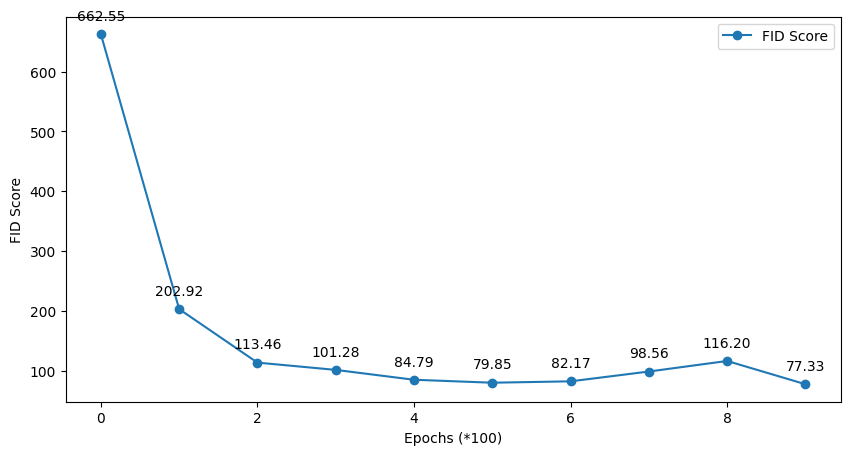

1/1 [==============================] - 0s 19ms/step


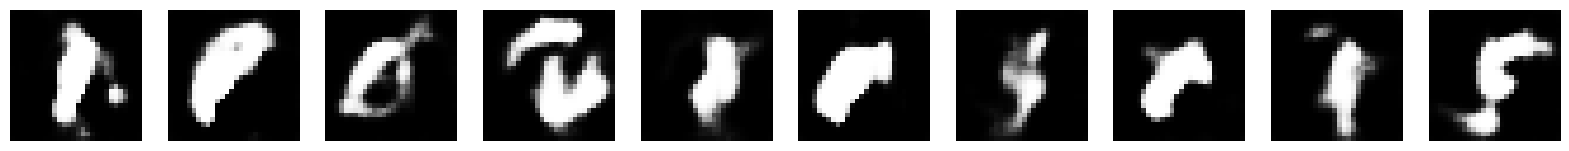

In [14]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

## CNN + Add 1 Converlution Layer For Generator +  FID

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from scipy.linalg import sqrtm
import numpy as np
import time
import matplotlib.pyplot as plt

np.random.seed(1000)
tf.random.set_seed(1000)

# input 100
# output 28*28*1

def build_generator():
    model = Sequential()
    
    # 增加维度
    model.add(Dense(7*7*128, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization(momentum=0.8))

    # 增加一个卷积层
    model.add(Conv2D(128, kernel_size=3, strides=1, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(1, kernel_size=7, activation='tanh', padding='same'))

    return model

# input 28*28*1
# output 1

def build_discriminator():
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)

# 计算FID函数
def calculate_fid(real_images, fake_images):
    act1 = real_images.reshape((real_images.shape[0], -1))
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    
    act2 = fake_images.reshape((fake_images.shape[0], -1))
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

def train_gan(epochs=1000, batch_size=64, p_epoch=100):
    generator = build_generator()
    discriminator = build_discriminator()

    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    half_batch = int(batch_size / 2)
    
    d_losses = []
    g_losses = []
    d_acc = []
    fid_scores = []
    
    start_time = time.time()  # Record the start time

    for epoch in range(epochs):
        # Select a random half batch of real images
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        # Generate a half batch of new fake images
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        # Train the discriminator
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_y)

        # Record the losses
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_acc.append(d_loss[1] * 100)
        
        # Calculate FID every p_epoch epochs
        if epoch % p_epoch == 0:
            noise = np.random.normal(0, 1, (1000, 100))
            fake_images = generator.predict(noise)
            fid = calculate_fid(x_train[:1000], fake_images)
            fid_scores.append(fid)
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}] [FID: {fid}]")

    end_time = time.time()  # Record the end time
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    return generator, d_losses, g_losses, d_acc, fid_scores

In [5]:
# Training the GAN with an additional convolution layer in the generator and FID calculation
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000, batch_size=64, p_epoch=100)

32/32 [==============================] - 1s 17ms/step
0 [D loss: 0.7034737765789032, acc.: 21.875%] [G loss: 0.6779304146766663] [FID: 682.2112717655597]
32/32 [==============================] - 1s 19ms/step
100 [D loss: 0.7102076411247253, acc.: 50.0%] [G loss: 0.7624412775039673] [FID: 175.42055907587957]
32/32 [==============================] - 1s 21ms/step
200 [D loss: 0.6825337707996368, acc.: 51.5625%] [G loss: 0.6899387836456299] [FID: 141.62025546141462]
32/32 [==============================] - 1s 19ms/step
300 [D loss: 0.7018324434757233, acc.: 45.3125%] [G loss: 0.7121515274047852] [FID: 84.95152953045273]
1/1 [==============================] - 0s 111ms/step


32/32 [==============================] - 1s 19ms/step
400 [D loss: 0.6912843286991119, acc.: 48.4375%] [G loss: 0.7051470279693604] [FID: 79.49652905266201]
32/32 [==============================] - 1s 19ms/step
500 [D loss: 0.6996573209762573, acc.: 51.5625%] [G loss: 0.7057504057884216] [FID: 73.32850890987118]
32/32 [==============================] - 1s 20ms/step
600 [D loss: 0.6980277895927429, acc.: 39.0625%] [G loss: 0.707772970199585] [FID: 72.70001789095429]
1/1 [==============================] - 0s 26ms/step


32/32 [==============================] - 1s 18ms/step
700 [D loss: 0.6962715089321136, acc.: 48.4375%] [G loss: 0.7051210403442383] [FID: 72.48781168598877]
32/32 [==============================] - 1s 19ms/step
800 [D loss: 0.6929795145988464, acc.: 53.125%] [G loss: 0.6927924752235413] [FID: 77.90287288853347]
32/32 [==============================] - 1s 18ms/step
900 [D loss: 0.6884296834468842, acc.: 53.125%] [G loss: 0.7022621035575867] [FID: 77.25188919709706]
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 29ms/step
Total training time: 203.29 seconds


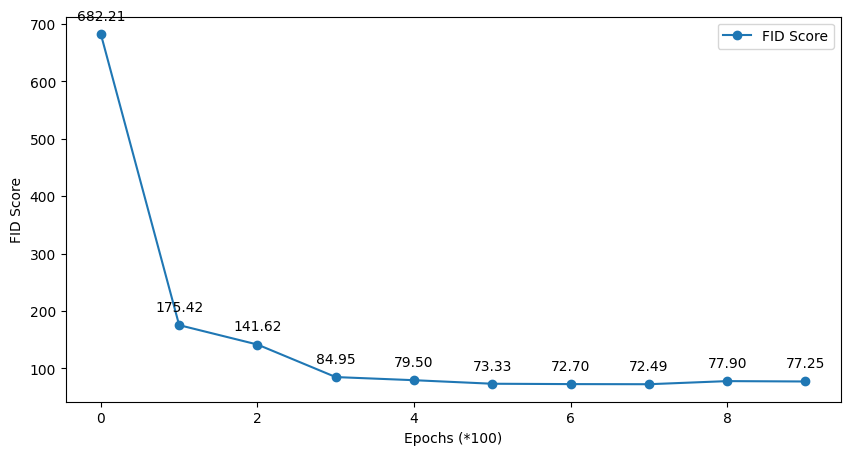

1/1 [==============================] - 0s 18ms/step


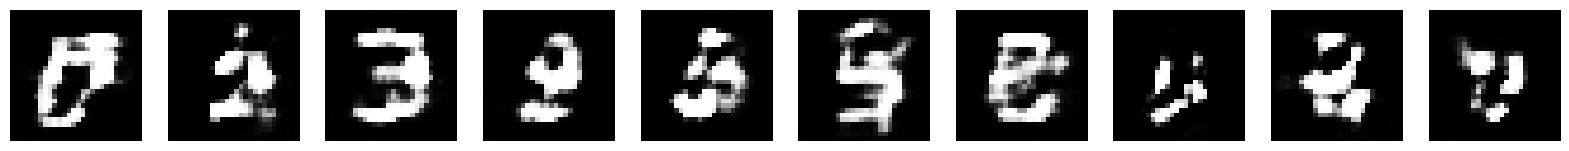

In [6]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [7]:
# Training the GAN with an additional convolution layer in the generator and FID calculation
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000, batch_size=64, p_epoch=100)

32/32 [==============================] - 1s 20ms/step
0 [D loss: 0.7005118727684021, acc.: 18.75%] [G loss: 0.6567097902297974] [FID: 726.5306192632456]
32/32 [==============================] - 1s 18ms/step
100 [D loss: 0.7827385067939758, acc.: 40.625%] [G loss: 0.620353102684021] [FID: 195.44378055143807]
32/32 [==============================] - 1s 18ms/step
200 [D loss: 0.7152296304702759, acc.: 37.5%] [G loss: 0.7074383497238159] [FID: 134.77889948023534]
32/32 [==============================] - 1s 16ms/step
300 [D loss: 0.6956676840782166, acc.: 50.0%] [G loss: 0.7066351175308228] [FID: 96.53151439661556]
1/1 [==============================] - 0s 120ms/step


32/32 [==============================] - 1s 19ms/step
400 [D loss: 0.6923466920852661, acc.: 50.0%] [G loss: 0.7221641540527344] [FID: 116.36907550315942]
32/32 [==============================] - 1s 18ms/step
500 [D loss: 0.7039638161659241, acc.: 45.3125%] [G loss: 0.6946252584457397] [FID: 118.17619053229723]
32/32 [==============================] - 1s 17ms/step
600 [D loss: 0.6950666010379791, acc.: 51.5625%] [G loss: 0.7065972685813904] [FID: 97.88794170246234]
1/1 [==============================] - 0s 25ms/step


32/32 [==============================] - 1s 18ms/step
700 [D loss: 0.692117840051651, acc.: 60.9375%] [G loss: 0.7132644653320312] [FID: 86.2896587946801]
32/32 [==============================] - 1s 19ms/step
800 [D loss: 0.6907480359077454, acc.: 54.6875%] [G loss: 0.6895477771759033] [FID: 93.61980928398975]
32/32 [==============================] - 1s 19ms/step
900 [D loss: 0.6901663839817047, acc.: 56.25%] [G loss: 0.7110356688499451] [FID: 81.13742257818109]
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 27ms/step
Total training time: 201.67 seconds


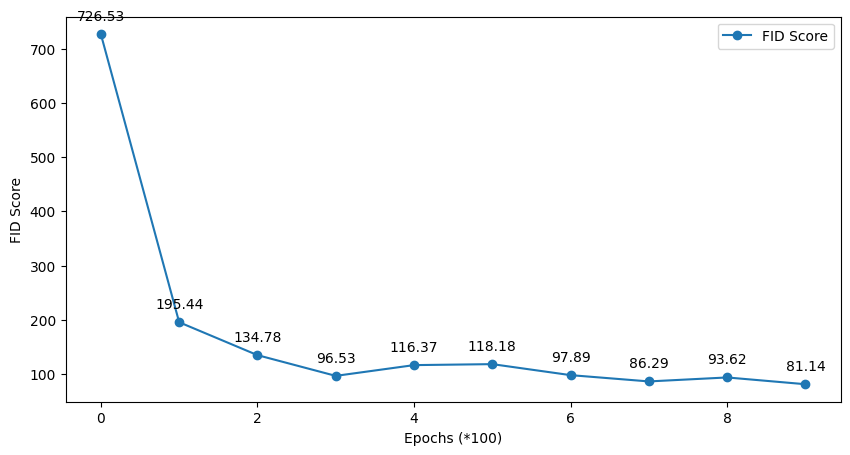

1/1 [==============================] - 0s 18ms/step


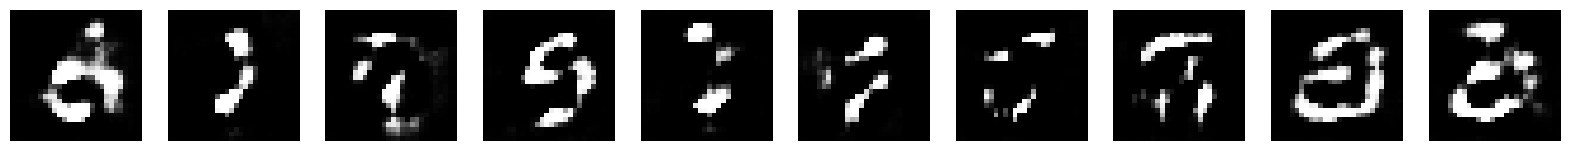

In [8]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [10]:
# Training the GAN with an additional convolution layer in the generator and FID calculation
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000, batch_size=64, p_epoch=100)

32/32 [==============================] - 1s 21ms/step
0 [D loss: 0.6878829896450043, acc.: 32.8125%] [G loss: 0.6564732193946838] [FID: 725.3336874717136]
32/32 [==============================] - 1s 21ms/step
100 [D loss: 0.6852212846279144, acc.: 54.6875%] [G loss: 0.7369474172592163] [FID: 172.26366539180125]
32/32 [==============================] - 1s 24ms/step
200 [D loss: 0.7070841491222382, acc.: 48.4375%] [G loss: 0.6698603630065918] [FID: 100.22960188641882]
32/32 [==============================] - 1s 18ms/step
300 [D loss: 0.6990039944648743, acc.: 43.75%] [G loss: 0.6983883380889893] [FID: 89.09483189100435]
1/1 [==============================] - 0s 125ms/step


32/32 [==============================] - 1s 22ms/step
400 [D loss: 0.7161516547203064, acc.: 37.5%] [G loss: 0.7102181315422058] [FID: 92.17317690355279]
32/32 [==============================] - 1s 21ms/step
500 [D loss: 0.7011274695396423, acc.: 46.875%] [G loss: 0.7063171863555908] [FID: 81.10684394909518]
32/32 [==============================] - 1s 21ms/step
600 [D loss: 0.6960110664367676, acc.: 45.3125%] [G loss: 0.7061740159988403] [FID: 65.05983910475332]
1/1 [==============================] - 0s 27ms/step


32/32 [==============================] - 1s 17ms/step
700 [D loss: 0.6835497915744781, acc.: 60.9375%] [G loss: 0.703488290309906] [FID: 97.40708712598224]
32/32 [==============================] - 1s 25ms/step
800 [D loss: 0.6963106989860535, acc.: 45.3125%] [G loss: 0.7036728262901306] [FID: 65.20295520121812]
32/32 [==============================] - 1s 22ms/step
900 [D loss: 0.6949912011623383, acc.: 45.3125%] [G loss: 0.7176671624183655] [FID: 78.45636836213421]
1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 28ms/step
Total training time: 227.64 seconds


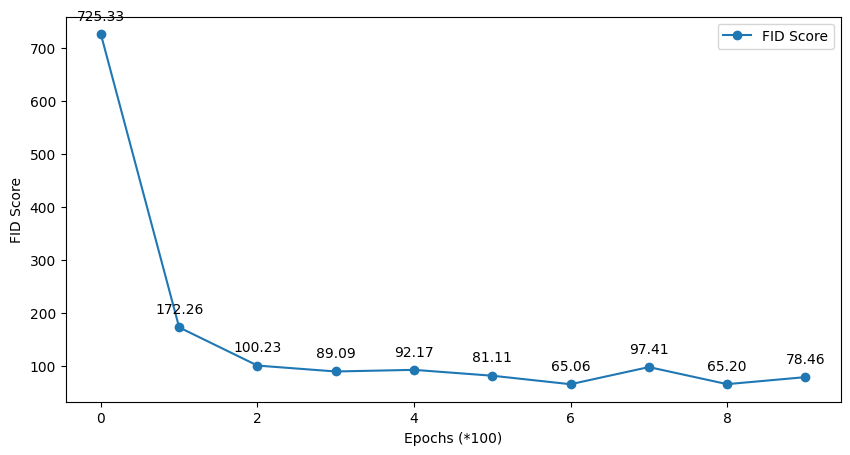

1/1 [==============================] - 0s 21ms/step


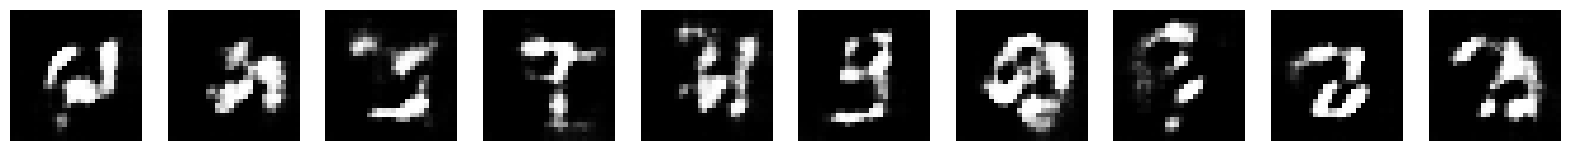

In [11]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

## CNN + Add 2 Converlution Layer For Generator +  FID

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from scipy.linalg import sqrtm
import numpy as np
import time
import matplotlib.pyplot as plt

np.random.seed(1000)
tf.random.set_seed(1000)

# input 100
# output 28*28*1

def build_generator():
    model = Sequential()
    
    # 增加维度
    model.add(Dense(7*7*128, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization(momentum=0.8))

    # 增加第一个卷积层
    model.add(Conv2D(128, kernel_size=3, strides=1, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    # 增加第二个卷积层
    model.add(Conv2D(128, kernel_size=3, strides=1, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(1, kernel_size=7, activation='tanh', padding='same'))

    return model

# input 28*28*1
# output 1

def build_discriminator():
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)

# 计算FID函数
def calculate_fid(real_images, fake_images):
    act1 = real_images.reshape((real_images.shape[0], -1))
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    
    act2 = fake_images.reshape((fake_images.shape[0], -1))
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

def train_gan(epochs=1000, batch_size=64, p_epoch=100):
    generator = build_generator()
    discriminator = build_discriminator()

    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    half_batch = int(batch_size / 2)
    
    d_losses = []
    g_losses = []
    d_acc = []
    fid_scores = []
    
    start_time = time.time()  # Record the start time

    for epoch in range(epochs):
        # Select a random half batch of real images
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        # Generate a half batch of new fake images
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        # Train the discriminator
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_y)

        # Record the losses
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_acc.append(d_loss[1] * 100)
        
        # Calculate FID every p_epoch epochs
        if epoch % p_epoch == 0:
            noise = np.random.normal(0, 1, (1000, 100))
            fake_images = generator.predict(noise)
            fid = calculate_fid(x_train[:1000], fake_images)
            fid_scores.append(fid)
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}] [FID: {fid}]")

    end_time = time.time()  # Record the end time
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    return generator, d_losses, g_losses, d_acc, fid_scores


In [13]:
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000)

32/32 [==============================] - 1s 24ms/step
0 [D loss: 0.7137671411037445, acc.: 21.875%] [G loss: 0.7242385149002075] [FID: 690.0535700759142]
32/32 [==============================] - 1s 19ms/step
100 [D loss: 0.7313380241394043, acc.: 48.4375%] [G loss: 0.6354193687438965] [FID: 222.6109347932396]
32/32 [==============================] - 1s 23ms/step
200 [D loss: 0.7013454437255859, acc.: 43.75%] [G loss: 0.6655079126358032] [FID: 134.53651423978198]
32/32 [==============================] - 1s 27ms/step
300 [D loss: 0.6897003650665283, acc.: 51.5625%] [G loss: 0.7270837426185608] [FID: 160.47235350860717]
1/1 [==============================] - 0s 53ms/step


32/32 [==============================] - 1s 23ms/step
400 [D loss: 0.7053632438182831, acc.: 42.1875%] [G loss: 0.7115585803985596] [FID: 153.4038710892659]
32/32 [==============================] - 1s 24ms/step
500 [D loss: 0.7037818431854248, acc.: 43.75%] [G loss: 0.7090083360671997] [FID: 101.64171690800276]
32/32 [==============================] - 1s 24ms/step
600 [D loss: 0.6912006139755249, acc.: 51.5625%] [G loss: 0.7227481603622437] [FID: 100.02558061102161]
1/1 [==============================] - 0s 28ms/step


32/32 [==============================] - 1s 24ms/step
700 [D loss: 0.6879103481769562, acc.: 59.375%] [G loss: 0.7210003137588501] [FID: 97.87606753183185]
32/32 [==============================] - 1s 24ms/step
800 [D loss: 0.6856004595756531, acc.: 57.8125%] [G loss: 0.7158194780349731] [FID: 79.50428474272769]
32/32 [==============================] - 1s 23ms/step
900 [D loss: 0.6858178079128265, acc.: 56.25%] [G loss: 0.7129643559455872] [FID: 90.14444773507829]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
Total training time: 244.50 seconds


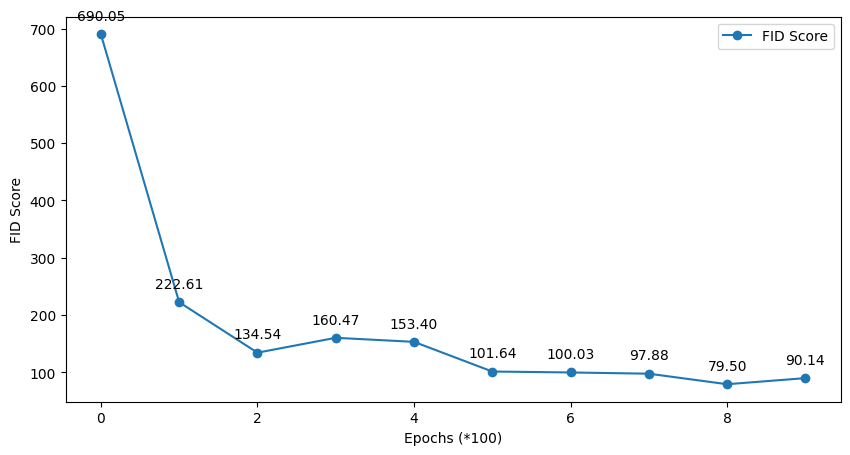

1/1 [==============================] - 0s 22ms/step


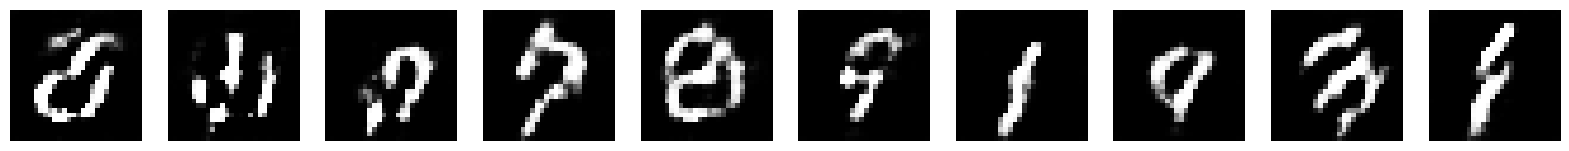

In [14]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [15]:
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000)

32/32 [==============================] - 1s 24ms/step
0 [D loss: 0.6588442623615265, acc.: 48.4375%] [G loss: 0.6035627722740173] [FID: 726.4636659869836]
32/32 [==============================] - 1s 23ms/step
100 [D loss: 0.7050339877605438, acc.: 56.25%] [G loss: 0.7062919735908508] [FID: 187.56015745497825]
32/32 [==============================] - 1s 24ms/step
200 [D loss: 0.7003729939460754, acc.: 40.625%] [G loss: 0.7059208154678345] [FID: 114.49547985619489]
32/32 [==============================] - 1s 25ms/step
300 [D loss: 0.6909565329551697, acc.: 57.8125%] [G loss: 0.7097581624984741] [FID: 111.80619184206222]
1/1 [==============================] - 0s 45ms/step


32/32 [==============================] - 1s 24ms/step
400 [D loss: 0.6888133883476257, acc.: 54.6875%] [G loss: 0.7223109006881714] [FID: 123.93177639749264]
32/32 [==============================] - 1s 24ms/step
500 [D loss: 0.7100314497947693, acc.: 42.1875%] [G loss: 0.7055522203445435] [FID: 134.08143750194742]
32/32 [==============================] - 1s 24ms/step
600 [D loss: 0.691262423992157, acc.: 50.0%] [G loss: 0.7089115381240845] [FID: 96.3327918968667]
1/1 [==============================] - 0s 33ms/step


32/32 [==============================] - 1s 22ms/step
700 [D loss: 0.6980521380901337, acc.: 43.75%] [G loss: 0.7080996036529541] [FID: 116.13265393987768]
32/32 [==============================] - 1s 24ms/step
800 [D loss: 0.6986199915409088, acc.: 45.3125%] [G loss: 0.6990115642547607] [FID: 91.11085092439014]
32/32 [==============================] - 1s 25ms/step
900 [D loss: 0.6966884434223175, acc.: 53.125%] [G loss: 0.6912174224853516] [FID: 85.96413455326044]
1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 28ms/step
Total training time: 247.17 seconds


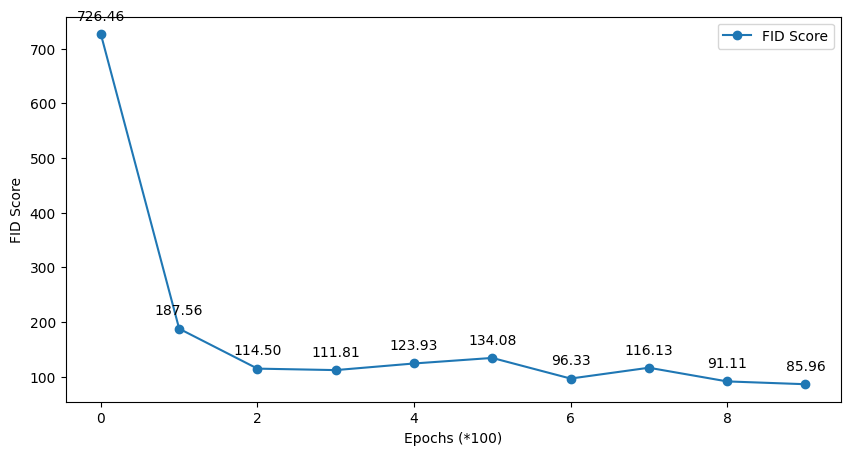

1/1 [==============================] - 0s 17ms/step


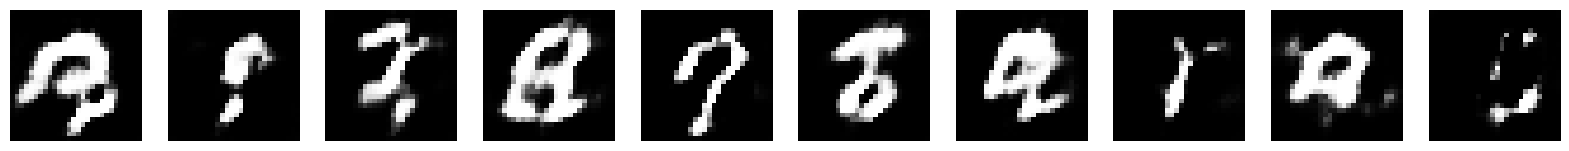

In [16]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [17]:
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000)

32/32 [==============================] - 1s 23ms/step
0 [D loss: 0.6936758756637573, acc.: 26.5625%] [G loss: 0.6625592708587646] [FID: 719.4278384542479]
32/32 [==============================] - 1s 23ms/step
100 [D loss: 0.6402033269405365, acc.: 65.625%] [G loss: 0.6735538244247437] [FID: 192.35916642955988]
32/32 [==============================] - 1s 25ms/step
200 [D loss: 0.663566380739212, acc.: 60.9375%] [G loss: 0.722351610660553] [FID: 159.10975063370736]
32/32 [==============================] - 1s 23ms/step
300 [D loss: 0.6710756123065948, acc.: 57.8125%] [G loss: 0.7394615411758423] [FID: 194.89135611130138]
1/1 [==============================] - 0s 71ms/step


32/32 [==============================] - 1s 23ms/step
400 [D loss: 0.6823405623435974, acc.: 65.625%] [G loss: 0.734474778175354] [FID: 224.33005315022444]
32/32 [==============================] - 1s 21ms/step
500 [D loss: 0.6985299289226532, acc.: 48.4375%] [G loss: 0.6914524435997009] [FID: 157.93675083249582]
32/32 [==============================] - 1s 25ms/step
600 [D loss: 0.7007741332054138, acc.: 45.3125%] [G loss: 0.7034424543380737] [FID: 135.66920939637808]
1/1 [==============================] - 0s 30ms/step


32/32 [==============================] - 1s 23ms/step
700 [D loss: 0.7063014805316925, acc.: 32.8125%] [G loss: 0.6877297163009644] [FID: 109.60770558892355]
32/32 [==============================] - 1s 24ms/step
800 [D loss: 0.6974162757396698, acc.: 50.0%] [G loss: 0.6941765546798706] [FID: 114.72264075895973]
32/32 [==============================] - 1s 23ms/step
900 [D loss: 0.6898780763149261, acc.: 50.0%] [G loss: 0.7079578042030334] [FID: 121.4192153573516]
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 32ms/step
Total training time: 241.13 seconds


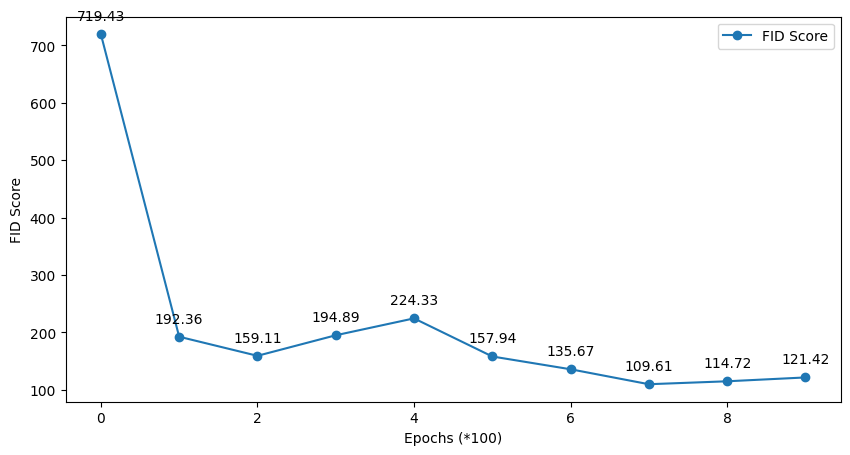

1/1 [==============================] - 0s 20ms/step


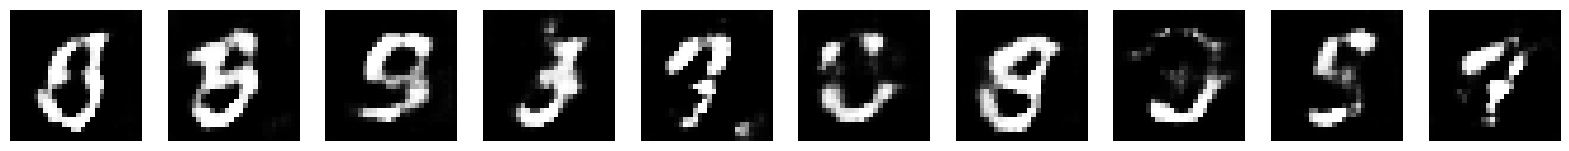

In [18]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

## CNN + Add 3 Converlution Layer For Generator + FID

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from scipy.linalg import sqrtm
import numpy as np
import time
import matplotlib.pyplot as plt

np.random.seed(1000)
tf.random.set_seed(1000)

# input 100
# output 28*28*1

def build_generator():
    model = Sequential()
    
    # 增加维度
    model.add(Dense(7*7*128, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization(momentum=0.8))

    # 增加第一个卷积层
    model.add(Conv2D(128, kernel_size=3, strides=1, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    # 增加第二个卷积层
    model.add(Conv2D(128, kernel_size=3, strides=1, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    # 增加第三个卷积层
    model.add(Conv2D(128, kernel_size=3, strides=1, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(1, kernel_size=7, activation='tanh', padding='same'))

    return model

# input 28*28*1
# output 1

def build_discriminator():
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)

# 计算FID函数
def calculate_fid(real_images, fake_images):
    act1 = real_images.reshape((real_images.shape[0], -1))
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    
    act2 = fake_images.reshape((fake_images.shape[0], -1))
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

def train_gan(epochs=1000, batch_size=64, p_epoch=100):
    generator = build_generator()
    discriminator = build_discriminator()

    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    half_batch = int(batch_size / 2)
    
    d_losses = []
    g_losses = []
    d_acc = []
    fid_scores = []
    
    start_time = time.time()  # Record the start time

    for epoch in range(epochs):
        # Select a random half batch of real images
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        # Generate a half batch of new fake images
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        # Train the discriminator
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_y)

        # Record the losses
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_acc.append(d_loss[1] * 100)
        
        # Calculate FID every p_epoch epochs
        if epoch % p_epoch == 0:
            noise = np.random.normal(0, 1, (1000, 100))
            fake_images = generator.predict(noise)
            fid = calculate_fid(x_train[:1000], fake_images)
            fid_scores.append(fid)
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}] [FID: {fid}]")

    end_time = time.time()  # Record the end time
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    return generator, d_losses, g_losses, d_acc, fid_scores


In [20]:
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000)

32/32 [==============================] - 1s 22ms/step
0 [D loss: 0.698088526725769, acc.: 25.0%] [G loss: 0.6724995970726013] [FID: 700.3624773367907]
32/32 [==============================] - 1s 29ms/step
100 [D loss: 0.7525805532932281, acc.: 31.25%] [G loss: 0.6836673021316528] [FID: 195.23923486545345]
32/32 [==============================] - 1s 24ms/step
200 [D loss: 0.720204085111618, acc.: 32.8125%] [G loss: 0.7140980362892151] [FID: 228.63002838596674]
32/32 [==============================] - 1s 24ms/step
300 [D loss: 0.7168844938278198, acc.: 35.9375%] [G loss: 0.6738612055778503] [FID: 149.78220546171465]
1/1 [==============================] - 0s 119ms/step


32/32 [==============================] - 1s 26ms/step
400 [D loss: 0.6520803272724152, acc.: 82.8125%] [G loss: 0.7642918825149536] [FID: 192.91456400153066]
32/32 [==============================] - 1s 24ms/step
500 [D loss: 0.6612838208675385, acc.: 71.875%] [G loss: 0.7488742470741272] [FID: 263.32991506298447]
32/32 [==============================] - 1s 26ms/step
600 [D loss: 0.7151046395301819, acc.: 35.9375%] [G loss: 0.6891238689422607] [FID: 192.2692411813365]
1/1 [==============================] - 0s 29ms/step


32/32 [==============================] - 1s 24ms/step
700 [D loss: 0.6999813914299011, acc.: 48.4375%] [G loss: 0.7194514274597168] [FID: 329.8768649195724]
32/32 [==============================] - 1s 24ms/step
800 [D loss: 0.7029584050178528, acc.: 40.625%] [G loss: 0.6763008236885071] [FID: 154.5286454805298]
32/32 [==============================] - 1s 27ms/step
900 [D loss: 0.7061353921890259, acc.: 42.1875%] [G loss: 0.6827911138534546] [FID: 151.54692520613156]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step
Total training time: 262.12 seconds


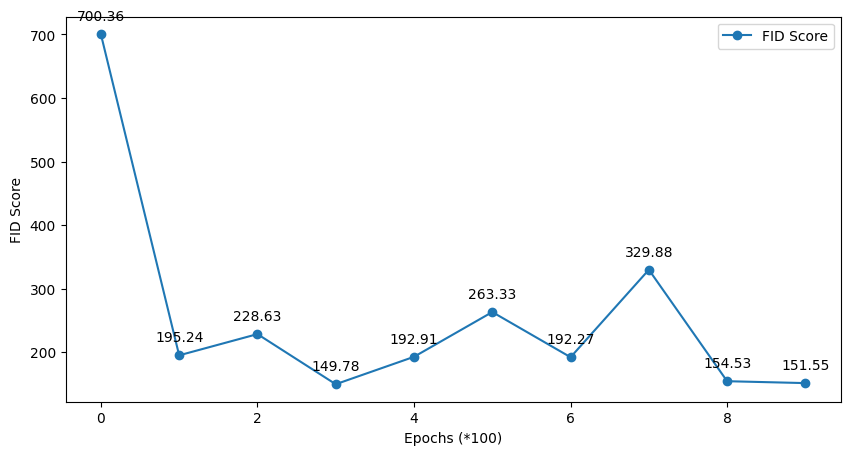

1/1 [==============================] - 0s 21ms/step


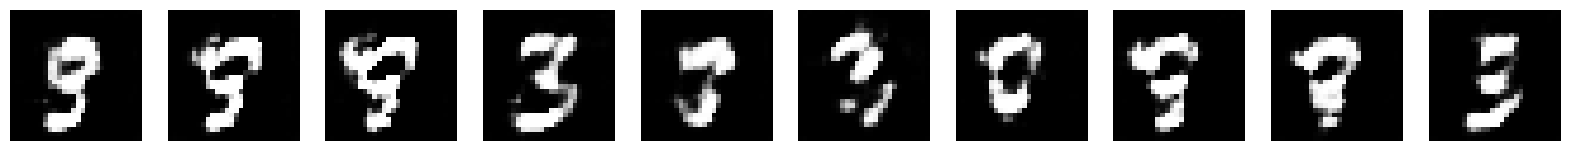

In [21]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [23]:
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000)

32/32 [==============================] - 1s 21ms/step
0 [D loss: 0.7027172446250916, acc.: 18.75%] [G loss: 0.6643992066383362] [FID: 646.7655405846906]
32/32 [==============================] - 1s 22ms/step
100 [D loss: 0.7253077030181885, acc.: 42.1875%] [G loss: 0.6630427837371826] [FID: 177.47516806083524]
32/32 [==============================] - 1s 22ms/step
200 [D loss: 0.7000455856323242, acc.: 43.75%] [G loss: 0.7257649302482605] [FID: 241.11438148082377]
32/32 [==============================] - 1s 24ms/step
300 [D loss: 0.6784529387950897, acc.: 64.0625%] [G loss: 0.7700307369232178] [FID: 244.66212073416284]
1/1 [==============================] - 0s 98ms/step


32/32 [==============================] - 1s 23ms/step
400 [D loss: 0.720897376537323, acc.: 34.375%] [G loss: 0.6899820566177368] [FID: 157.90512748445013]
32/32 [==============================] - 1s 22ms/step
500 [D loss: 0.7186178863048553, acc.: 29.6875%] [G loss: 0.7024016380310059] [FID: 215.81922361888604]
32/32 [==============================] - 1s 23ms/step
600 [D loss: 0.7186676561832428, acc.: 26.5625%] [G loss: 0.6674752235412598] [FID: 167.27820711605716]
1/1 [==============================] - 0s 26ms/step


32/32 [==============================] - 1s 28ms/step
700 [D loss: 0.6900869905948639, acc.: 60.9375%] [G loss: 0.7199934720993042] [FID: 168.07747521405733]
32/32 [==============================] - 1s 28ms/step
800 [D loss: 0.7005670070648193, acc.: 51.5625%] [G loss: 0.7259808778762817] [FID: 151.40926583834346]
32/32 [==============================] - 1s 24ms/step
900 [D loss: 0.6936947107315063, acc.: 53.125%] [G loss: 0.7176256775856018] [FID: 147.52841368838787]
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step
Total training time: 236.85 seconds


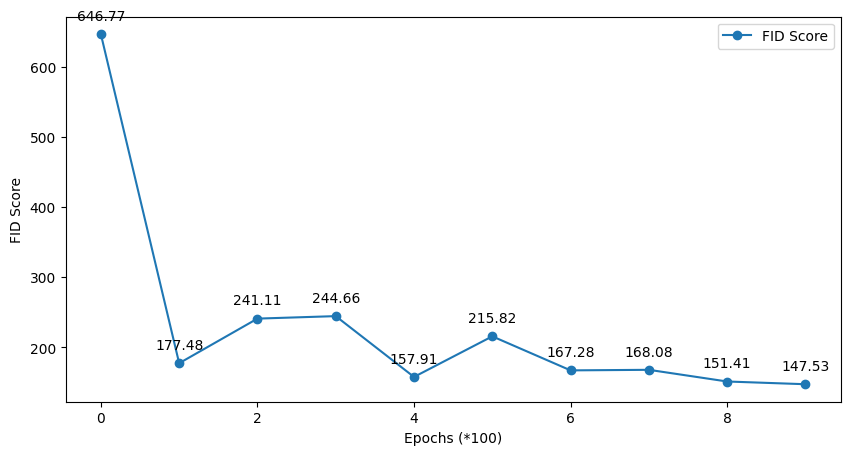

1/1 [==============================] - 0s 19ms/step


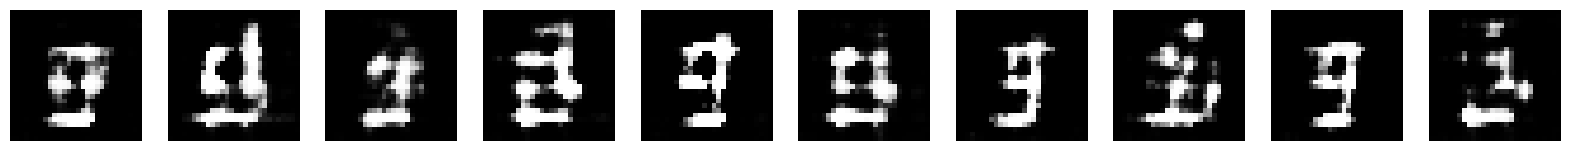

In [24]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [25]:
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000)

32/32 [==============================] - 1s 23ms/step
0 [D loss: 0.7275739014148712, acc.: 4.6875%] [G loss: 0.7114531993865967] [FID: 697.5157485907648]
32/32 [==============================] - 1s 25ms/step
100 [D loss: 0.7438149154186249, acc.: 21.875%] [G loss: 0.6978941559791565] [FID: 178.22081360073585]
32/32 [==============================] - 1s 24ms/step
200 [D loss: 0.697486937046051, acc.: 53.125%] [G loss: 0.7355762720108032] [FID: 225.1689430378596]
32/32 [==============================] - 1s 22ms/step
300 [D loss: 0.6770228445529938, acc.: 62.5%] [G loss: 0.7765984535217285] [FID: 266.664989741203]
1/1 [==============================] - 0s 82ms/step


32/32 [==============================] - 1s 24ms/step
400 [D loss: 0.7421344816684723, acc.: 26.5625%] [G loss: 0.6662853360176086] [FID: 259.71372771514245]
32/32 [==============================] - 1s 25ms/step
500 [D loss: 0.669900119304657, acc.: 62.5%] [G loss: 0.8181705474853516] [FID: 282.7558845680171]
32/32 [==============================] - 1s 27ms/step
600 [D loss: 0.6885654926300049, acc.: 53.125%] [G loss: 0.7322143912315369] [FID: 309.4037309954291]
1/1 [==============================] - 0s 34ms/step


32/32 [==============================] - 1s 27ms/step
700 [D loss: 0.67967689037323, acc.: 64.0625%] [G loss: 0.7752572298049927] [FID: 362.07227370709234]
32/32 [==============================] - 1s 26ms/step
800 [D loss: 0.6991543173789978, acc.: 50.0%] [G loss: 0.7496892213821411] [FID: 382.6996902109685]
32/32 [==============================] - 1s 25ms/step
900 [D loss: 0.6932387053966522, acc.: 56.25%] [G loss: 0.7608447074890137] [FID: 284.9055052328823]
1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 29ms/step
Total training time: 249.39 seconds


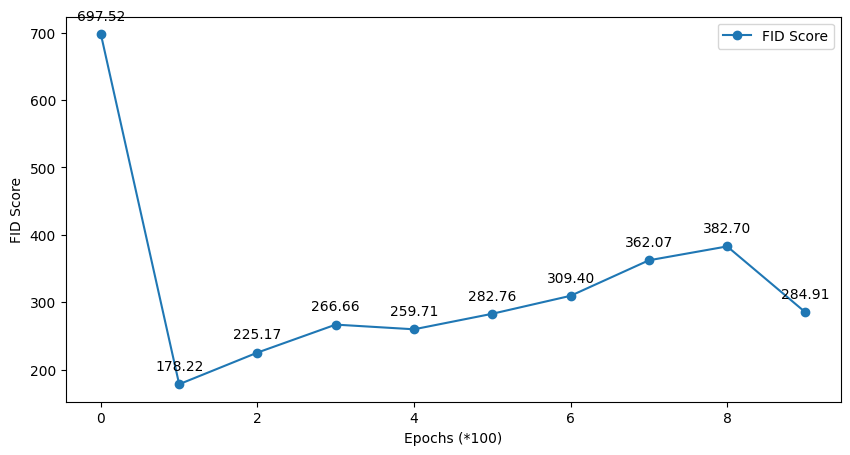

1/1 [==============================] - 0s 24ms/step


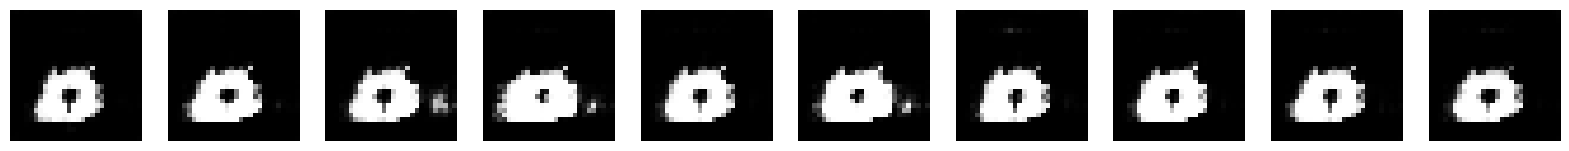

In [26]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

## CNN + Add 3 Converlution Layer For Generator + 1 Converlution layer for discriminator+ FID

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from scipy.linalg import sqrtm
import numpy as np
import time
import matplotlib.pyplot as plt

np.random.seed(1000)
tf.random.set_seed(1000)

# input 100
# output 28*28*1

def build_generator():
    model = Sequential()
    
    # 增加维度
    model.add(Dense(7*7*128, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization(momentum=0.8))

    # 增加第一个卷积层
    model.add(Conv2D(128, kernel_size=3, strides=1, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    # 增加第二个卷积层
    model.add(Conv2D(128, kernel_size=3, strides=1, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    # 增加第三个卷积层
    model.add(Conv2D(128, kernel_size=3, strides=1, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(1, kernel_size=7, activation='tanh', padding='same'))

    return model

# input 28*28*1
# output 1

def build_discriminator():
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    # 增加一个卷积层
    model.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)

# 计算FID函数
def calculate_fid(real_images, fake_images):
    act1 = real_images.reshape((real_images.shape[0], -1))
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    
    act2 = fake_images.reshape((fake_images.shape[0], -1))
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

def train_gan(epochs=1000, batch_size=64, p_epoch=100):
    generator = build_generator()
    discriminator = build_discriminator()

    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    half_batch = int(batch_size / 2)
    
    d_losses = []
    g_losses = []
    d_acc = []
    fid_scores = []
    
    start_time = time.time()  # Record the start time

    for epoch in range(epochs):
        # Select a random half batch of real images
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        # Generate a half batch of new fake images
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        # Train the discriminator
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_y)

        # Record the losses
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_acc.append(d_loss[1] * 100)
        
        # Calculate FID every p_epoch epochs
        if epoch % p_epoch == 0:
            noise = np.random.normal(0, 1, (1000, 100))
            fake_images = generator.predict(noise)
            fid = calculate_fid(x_train[:1000], fake_images)
            fid_scores.append(fid)
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}] [FID: {fid}]")

    end_time = time.time()  # Record the end time
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    return generator, d_losses, g_losses, d_acc, fid_scores

In [29]:
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000)

32/32 [==============================] - 1s 23ms/step
0 [D loss: 0.678681880235672, acc.: 45.3125%] [G loss: 0.6534611582756042] [FID: 701.9954558448476]
32/32 [==============================] - 1s 22ms/step
100 [D loss: 0.7329556941986084, acc.: 37.5%] [G loss: 0.6609561443328857] [FID: 139.35111583400612]
32/32 [==============================] - 1s 24ms/step
200 [D loss: 0.6994944214820862, acc.: 42.1875%] [G loss: 0.7084140777587891] [FID: 164.38601095665342]
32/32 [==============================] - 1s 22ms/step
300 [D loss: 0.7000336050987244, acc.: 43.75%] [G loss: 0.7049144506454468] [FID: 128.86967538147456]
1/1 [==============================] - 0s 38ms/step


32/32 [==============================] - 1s 23ms/step
400 [D loss: 0.6961588263511658, acc.: 45.3125%] [G loss: 0.7011053562164307] [FID: 112.73392930114804]
32/32 [==============================] - 1s 25ms/step
500 [D loss: 0.6894717514514923, acc.: 53.125%] [G loss: 0.7074344754219055] [FID: 97.07415030165971]
32/32 [==============================] - 1s 24ms/step
600 [D loss: 0.6756878793239594, acc.: 67.1875%] [G loss: 0.7022315263748169] [FID: 98.29535991692337]
1/1 [==============================] - 0s 29ms/step


32/32 [==============================] - 1s 24ms/step
700 [D loss: 0.6915144324302673, acc.: 57.8125%] [G loss: 0.715741753578186] [FID: 133.09382781197922]
32/32 [==============================] - 1s 25ms/step
800 [D loss: 0.6821150183677673, acc.: 62.5%] [G loss: 0.729787290096283] [FID: 106.94912677841928]
32/32 [==============================] - 1s 25ms/step
900 [D loss: 0.6953097581863403, acc.: 42.1875%] [G loss: 0.6941630244255066] [FID: 70.27308384052324]
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step
Total training time: 266.33 seconds


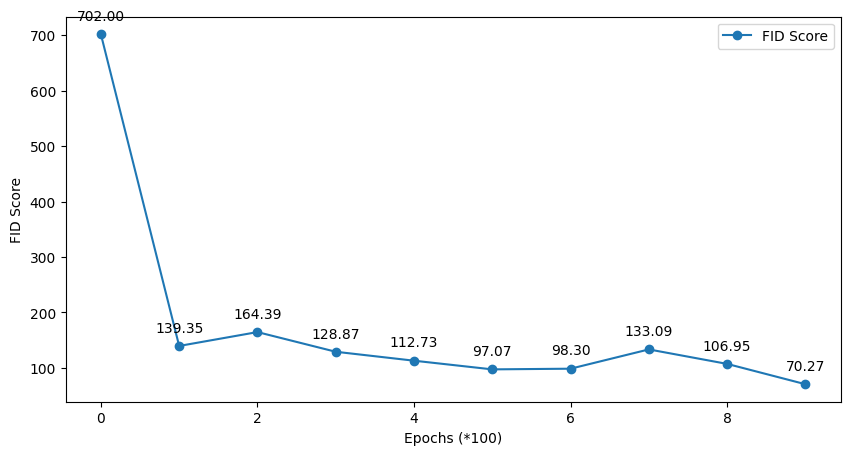

1/1 [==============================] - 0s 22ms/step


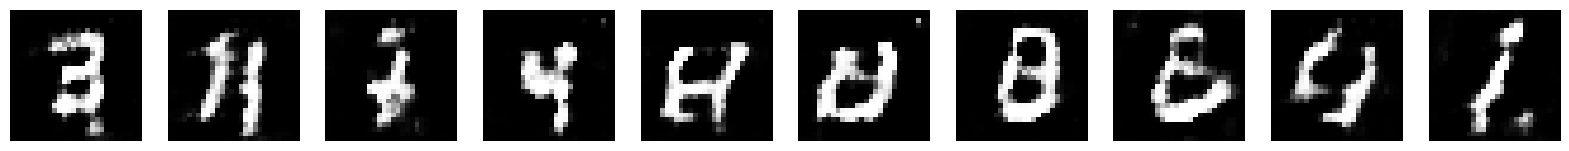

In [30]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [31]:
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000)

32/32 [==============================] - 1s 21ms/step
0 [D loss: 0.7177878618240356, acc.: 0.0%] [G loss: 0.6801568865776062] [FID: 667.3522550559039]
32/32 [==============================] - 1s 22ms/step
100 [D loss: 0.6471269130706787, acc.: 62.5%] [G loss: 0.8100980520248413] [FID: 221.75983112333932]
32/32 [==============================] - 1s 20ms/step
200 [D loss: 0.6865606606006622, acc.: 53.125%] [G loss: 0.7349300980567932] [FID: 130.82905415759166]
32/32 [==============================] - 1s 23ms/step
300 [D loss: 0.7030903100967407, acc.: 42.1875%] [G loss: 0.7604881525039673] [FID: 136.48664113709432]
1/1 [==============================] - 0s 64ms/step


32/32 [==============================] - 1s 25ms/step
400 [D loss: 0.6858735978603363, acc.: 57.8125%] [G loss: 0.7301830053329468] [FID: 122.87773004720047]
32/32 [==============================] - 1s 23ms/step
500 [D loss: 0.6853491067886353, acc.: 60.9375%] [G loss: 0.7285555005073547] [FID: 134.4788576994282]
32/32 [==============================] - 1s 21ms/step
600 [D loss: 0.6569069921970367, acc.: 75.0%] [G loss: 0.7704952955245972] [FID: 125.64875089928645]
1/1 [==============================] - 0s 32ms/step


32/32 [==============================] - 1s 24ms/step
700 [D loss: 0.6946358680725098, acc.: 54.6875%] [G loss: 0.7326153516769409] [FID: 80.35873574915452]
32/32 [==============================] - 1s 23ms/step
800 [D loss: 0.6627494394779205, acc.: 65.625%] [G loss: 0.8288094401359558] [FID: 100.56971620685462]
32/32 [==============================] - 1s 22ms/step
900 [D loss: 0.6845434010028839, acc.: 62.5%] [G loss: 0.7129107713699341] [FID: 72.96609027896565]
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step
Total training time: 241.75 seconds


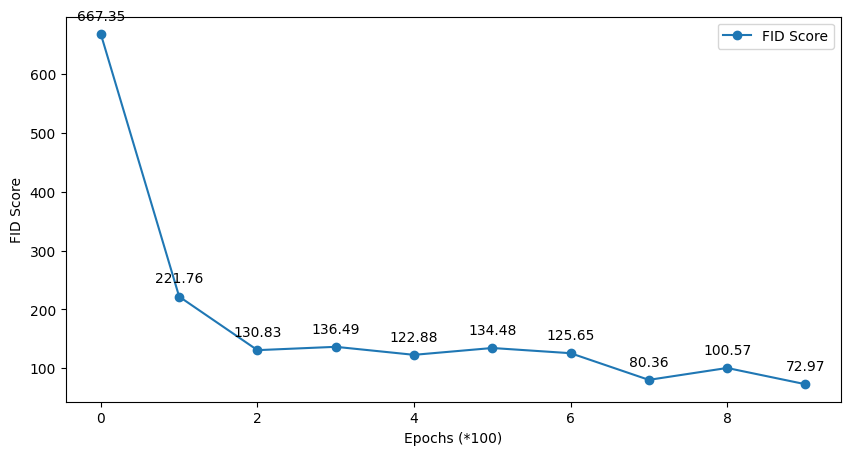

1/1 [==============================] - 0s 21ms/step


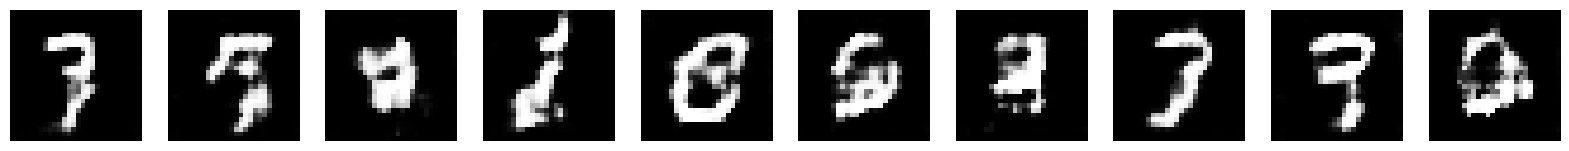

In [32]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [33]:
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000)

32/32 [==============================] - 1s 25ms/step
0 [D loss: 0.7190023958683014, acc.: 4.6875%] [G loss: 0.6539279222488403] [FID: 685.3917238556412]
32/32 [==============================] - 1s 21ms/step
100 [D loss: 0.6418652236461639, acc.: 56.25%] [G loss: 0.6839262843132019] [FID: 159.65253040729203]
32/32 [==============================] - 1s 21ms/step
200 [D loss: 0.7347534596920013, acc.: 29.6875%] [G loss: 0.6988424062728882] [FID: 103.88943263013635]
32/32 [==============================] - 1s 23ms/step
300 [D loss: 0.6993994116783142, acc.: 50.0%] [G loss: 0.753391444683075] [FID: 117.27627660967991]
1/1 [==============================] - 0s 68ms/step


32/32 [==============================] - 1s 24ms/step
400 [D loss: 0.6903494894504547, acc.: 48.4375%] [G loss: 0.7298254370689392] [FID: 102.28019861764992]
32/32 [==============================] - 1s 23ms/step
500 [D loss: 0.6965835392475128, acc.: 50.0%] [G loss: 0.7243775129318237] [FID: 97.25237616678486]
32/32 [==============================] - 1s 23ms/step
600 [D loss: 0.6810020804405212, acc.: 65.625%] [G loss: 0.7136228084564209] [FID: 86.42712330114762]
1/1 [==============================] - 0s 31ms/step


32/32 [==============================] - 1s 22ms/step
700 [D loss: 0.6884957253932953, acc.: 53.125%] [G loss: 0.7027056813240051] [FID: 106.14021073320345]
32/32 [==============================] - 1s 23ms/step
800 [D loss: 0.6923519968986511, acc.: 56.25%] [G loss: 0.7094482183456421] [FID: 68.48784315551671]
32/32 [==============================] - 1s 22ms/step
900 [D loss: 0.6876106858253479, acc.: 48.4375%] [G loss: 0.715842604637146] [FID: 70.92706086834977]
1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 28ms/step
Total training time: 250.13 seconds


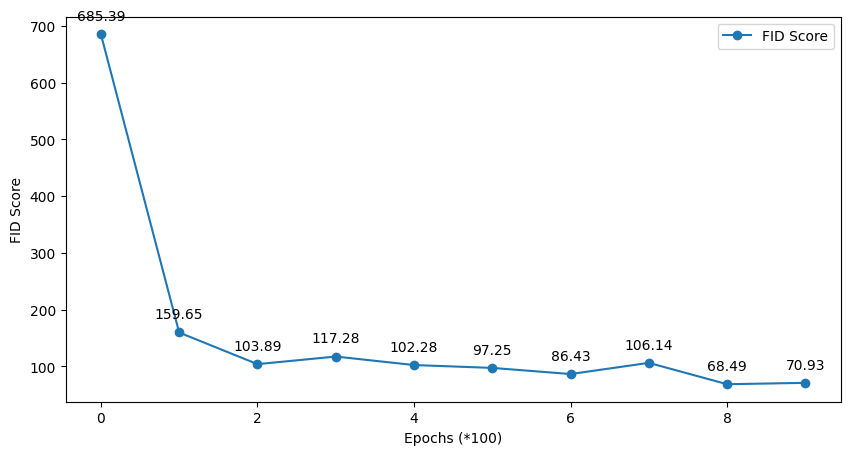

1/1 [==============================] - 0s 21ms/step


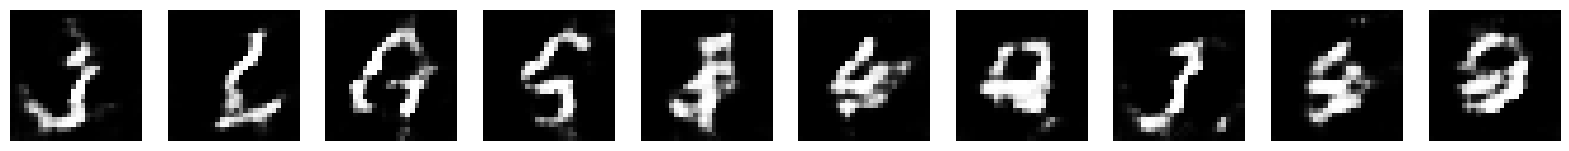

In [34]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

## CNN + Add 3 Converlution Layer For Generator + 2 Converlution layer for discriminator+ FID

In [35]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from scipy.linalg import sqrtm
import numpy as np
import time
import matplotlib.pyplot as plt

np.random.seed(1000)
tf.random.set_seed(1000)

# input 100
# output 28*28*1

def build_generator():
    model = Sequential()
    
    # 增加维度
    model.add(Dense(7*7*128, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization(momentum=0.8))

    # 增加第一个卷积层
    model.add(Conv2D(128, kernel_size=3, strides=1, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    # 增加第二个卷积层
    model.add(Conv2D(128, kernel_size=3, strides=1, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    # 增加第三个卷积层
    model.add(Conv2D(128, kernel_size=3, strides=1, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(1, kernel_size=7, activation='tanh', padding='same'))

    return model

# input 28*28*1
# output 1

def build_discriminator():
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    # 增加一个卷积层
    model.add(Conv2D(512, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    # 再增加一个卷积层
    model.add(Conv2D(1024, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)

# 计算FID函数
def calculate_fid(real_images, fake_images):
    act1 = real_images.reshape((real_images.shape[0], -1))
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    
    act2 = fake_images.reshape((fake_images.shape[0], -1))
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

def train_gan(epochs=1000, batch_size=64, p_epoch=100):
    generator = build_generator()
    discriminator = build_discriminator()

    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    half_batch = int(batch_size / 2)
    
    d_losses = []
    g_losses = []
    d_acc = []
    fid_scores = []
    
    start_time = time.time()  # Record the start time

    for epoch in range(epochs):
        # Select a random half batch of real images
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        # Generate a half batch of new fake images
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        # Train the discriminator
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_y)

        # Record the losses
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_acc.append(d_loss[1] * 100)
        
        # Calculate FID every p_epoch epochs
        if epoch % p_epoch == 0:
            noise = np.random.normal(0, 1, (1000, 100))
            fake_images = generator.predict(noise)
            fid = calculate_fid(x_train[:1000], fake_images)
            fid_scores.append(fid)
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}] [FID: {fid}]")

    end_time = time.time()  # Record the end time
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    return generator, d_losses, g_losses, d_acc, fid_scores

In [36]:
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000)

32/32 [==============================] - 1s 21ms/step
0 [D loss: 0.7003184854984283, acc.: 6.25%] [G loss: 0.6293172836303711] [FID: 666.6285427578559]
32/32 [==============================] - 1s 20ms/step
100 [D loss: 0.36553530395030975, acc.: 90.625%] [G loss: 2.761381149291992] [FID: 195.78505912420437]
32/32 [==============================] - 1s 19ms/step
200 [D loss: 0.640709638595581, acc.: 62.5%] [G loss: 1.2119075059890747] [FID: 108.01727948462019]
32/32 [==============================] - 1s 21ms/step
300 [D loss: 0.6901434659957886, acc.: 59.375%] [G loss: 0.969933032989502] [FID: 63.499867368345726]
1/1 [==============================] - 0s 63ms/step


32/32 [==============================] - 1s 20ms/step
400 [D loss: 0.6403270959854126, acc.: 67.1875%] [G loss: 1.0472310781478882] [FID: 53.97944394027027]
32/32 [==============================] - 1s 22ms/step
500 [D loss: 0.6480210721492767, acc.: 57.8125%] [G loss: 1.1450095176696777] [FID: 56.439584899182066]
32/32 [==============================] - 1s 21ms/step
600 [D loss: 0.6303926110267639, acc.: 68.75%] [G loss: 1.1020305156707764] [FID: 52.01077934525256]
1/1 [==============================] - 0s 28ms/step


32/32 [==============================] - 1s 20ms/step
700 [D loss: 0.5646303594112396, acc.: 70.3125%] [G loss: 0.9118473529815674] [FID: 38.64399577916828]
32/32 [==============================] - 1s 21ms/step
800 [D loss: 0.7307207584381104, acc.: 45.3125%] [G loss: 0.9835649728775024] [FID: 35.48490956852278]
32/32 [==============================] - 1s 21ms/step
900 [D loss: 0.6030537486076355, acc.: 67.1875%] [G loss: 0.9303919076919556] [FID: 37.40870614074842]
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 31ms/step
Total training time: 635.24 seconds


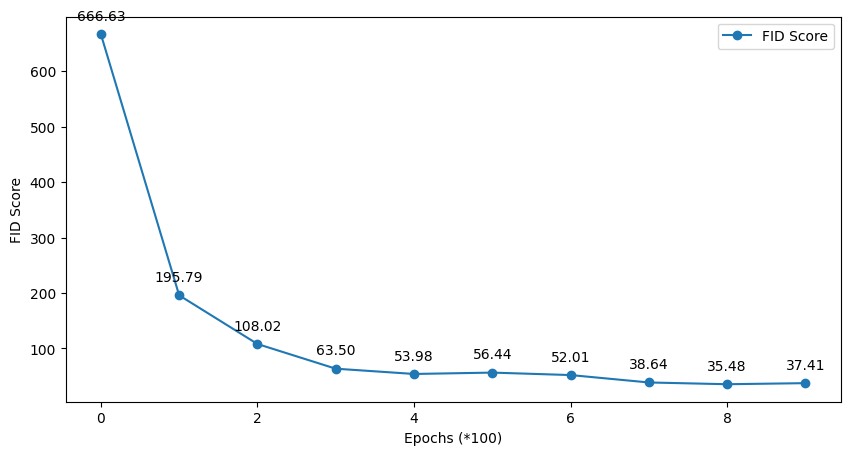

1/1 [==============================] - 0s 18ms/step


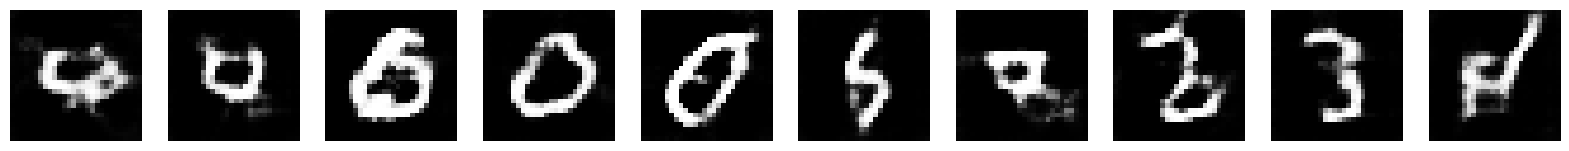

In [37]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [38]:
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000)

32/32 [==============================] - 1s 21ms/step
0 [D loss: 0.6949297487735748, acc.: 28.125%] [G loss: 0.6127086281776428] [FID: 708.4220517474392]
32/32 [==============================] - 1s 20ms/step
100 [D loss: 0.6807847619056702, acc.: 51.5625%] [G loss: 1.5568304061889648] [FID: 186.1338056688886]
32/32 [==============================] - 1s 21ms/step
200 [D loss: 0.6434308886528015, acc.: 60.9375%] [G loss: 0.8988902568817139] [FID: 102.64610950214185]
32/32 [==============================] - 1s 20ms/step
300 [D loss: 0.6630838513374329, acc.: 59.375%] [G loss: 0.9283071756362915] [FID: 95.69984088856926]
1/1 [==============================] - 0s 75ms/step


32/32 [==============================] - 1s 21ms/step
400 [D loss: 0.7436481416225433, acc.: 50.0%] [G loss: 0.8968159556388855] [FID: 78.02694749735547]
32/32 [==============================] - 1s 20ms/step
500 [D loss: 0.6631834506988525, acc.: 56.25%] [G loss: 0.9568041563034058] [FID: 67.48281570829249]
32/32 [==============================] - 1s 21ms/step
600 [D loss: 0.6740056872367859, acc.: 57.8125%] [G loss: 0.8381878733634949] [FID: 65.73505942274407]
1/1 [==============================] - 0s 32ms/step


32/32 [==============================] - 1s 19ms/step
700 [D loss: 0.673072874546051, acc.: 56.25%] [G loss: 0.9642996788024902] [FID: 67.0833678940063]
32/32 [==============================] - 1s 19ms/step
800 [D loss: 0.612473726272583, acc.: 60.9375%] [G loss: 0.9846094846725464] [FID: 36.41655552093684]
32/32 [==============================] - 1s 20ms/step
900 [D loss: 0.6236042380332947, acc.: 68.75%] [G loss: 0.9069226980209351] [FID: 42.251975014089254]
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 31ms/step
Total training time: 630.60 seconds


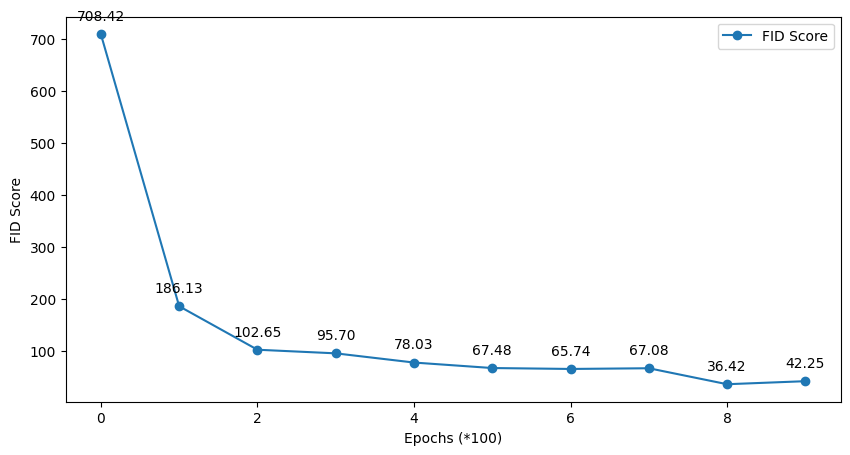

1/1 [==============================] - 0s 19ms/step


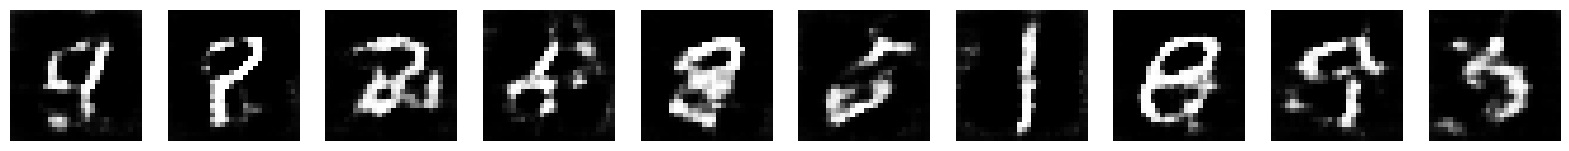

In [39]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [40]:
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000)

32/32 [==============================] - 1s 19ms/step
0 [D loss: 0.6899779438972473, acc.: 45.3125%] [G loss: 0.6073348522186279] [FID: 768.1612992421426]
32/32 [==============================] - 1s 21ms/step
100 [D loss: 0.6192097067832947, acc.: 68.75%] [G loss: 1.1591309309005737] [FID: 126.38843001493163]
32/32 [==============================] - 1s 20ms/step
200 [D loss: 0.6214466989040375, acc.: 68.75%] [G loss: 0.9199456572532654] [FID: 96.44760438156536]
32/32 [==============================] - 1s 20ms/step
300 [D loss: 0.7144765853881836, acc.: 59.375%] [G loss: 0.8284618854522705] [FID: 79.19894657638378]
1/1 [==============================] - 0s 79ms/step


32/32 [==============================] - 1s 20ms/step
400 [D loss: 0.6858173906803131, acc.: 57.8125%] [G loss: 0.9520270824432373] [FID: 67.83824435938648]
32/32 [==============================] - 1s 20ms/step
500 [D loss: 0.6128687858581543, acc.: 79.6875%] [G loss: 1.0156584978103638] [FID: 52.39074899889374]
32/32 [==============================] - 1s 19ms/step
600 [D loss: 0.6693996787071228, acc.: 60.9375%] [G loss: 0.8685474395751953] [FID: 42.2553203167265]
1/1 [==============================] - 0s 24ms/step


32/32 [==============================] - 1s 19ms/step
700 [D loss: 0.6749307513237, acc.: 59.375%] [G loss: 0.8817545175552368] [FID: 36.91831769659306]
32/32 [==============================] - 1s 19ms/step
800 [D loss: 0.6001635491847992, acc.: 70.3125%] [G loss: 0.7962146401405334] [FID: 38.29467005691491]
32/32 [==============================] - 1s 21ms/step
900 [D loss: 0.6529852449893951, acc.: 57.8125%] [G loss: 0.8768312931060791] [FID: 31.426195948230806]
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step
Total training time: 628.72 seconds


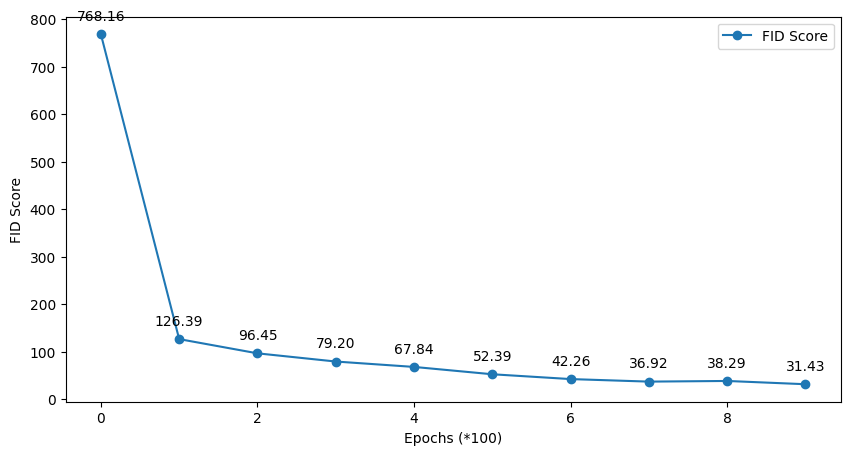

1/1 [==============================] - 0s 20ms/step


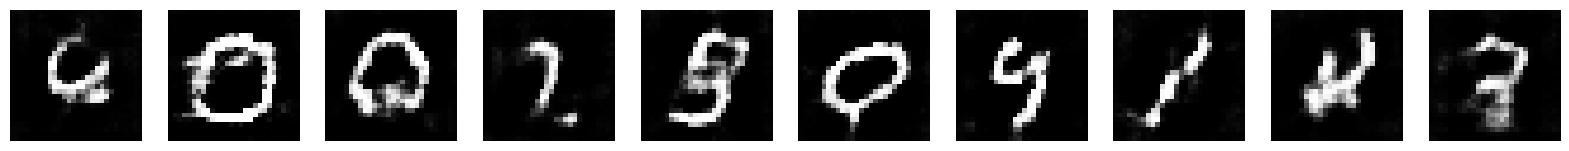

In [41]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

## CNN + Add 3 Converlution Layer For Generator + 3 Converlution layer for discriminator+ FID

In [49]:
def build_generator():
    model = Sequential()
    
    # 增加维度
    model.add(Dense(7*7*128, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization(momentum=0.8))

    # 增加第一个卷积层
    model.add(Conv2D(128, kernel_size=3, strides=1, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    # 增加第二个卷积层
    model.add(Conv2D(128, kernel_size=3, strides=1, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    # 增加第三个卷积层
    model.add(Conv2D(128, kernel_size=3, strides=1, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(1, kernel_size=7, activation='tanh', padding='same'))

    return model

def build_discriminator():
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    # 增加一个卷积层
    model.add(Conv2D(512, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    # 再增加一个卷积层
    model.add(Conv2D(1024, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    # 再增加一个卷积层
    model.add(Conv2D(2048, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model




import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from scipy.linalg import sqrtm
import numpy as np
import time
import matplotlib.pyplot as plt

np.random.seed(1000)
tf.random.set_seed(1000)

(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)

# 计算FID函数
def calculate_fid(real_images, fake_images):
    act1 = real_images.reshape((real_images.shape[0], -1))
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    
    act2 = fake_images.reshape((fake_images.shape[0], -1))
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

def train_gan(epochs=1000, batch_size=64, p_epoch=100):
    generator = build_generator()
    discriminator = build_discriminator()

    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    half_batch = int(batch_size / 2)
    
    d_losses = []
    g_losses = []
    d_acc = []
    fid_scores = []
    
    start_time = time.time()  # Record the start time

    for epoch in range(epochs):
        # Select a random half batch of real images
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        # Generate a half batch of new fake images
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        # Train the discriminator
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_y)

        # Record the losses
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_acc.append(d_loss[1] * 100)
        
        # Calculate FID every p_epoch epochs
        if epoch % p_epoch == 0:
            noise = np.random.normal(0, 1, (1000, 100))
            fake_images = generator.predict(noise)
            fid = calculate_fid(x_train[:1000], fake_images)
            fid_scores.append(fid)
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}] [FID: {fid}]")

    end_time = time.time()  # Record the end time
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    return generator, d_losses, g_losses, d_acc, fid_scores

In [50]:
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000)

1/1 [==============================] - 0s 78ms/step


32/32 [==============================] - 1s 22ms/step
0 [D loss: 0.6956865191459656, acc.: 15.625%] [G loss: 0.6632464528083801] [FID: 680.8455085862224]
32/32 [==============================] - 1s 20ms/step
100 [D loss: 0.3131343424320221, acc.: 90.625%] [G loss: 2.968233585357666] [FID: 149.2266279519779]
32/32 [==============================] - 1s 22ms/step
200 [D loss: 0.6343121975660324, acc.: 60.9375%] [G loss: 1.3412401676177979] [FID: 80.68863017203986]
32/32 [==============================] - 1s 23ms/step
300 [D loss: 0.645534098148346, acc.: 62.5%] [G loss: 1.3663721084594727] [FID: 70.00551911138848]
1/1 [==============================] - 0s 29ms/step


32/32 [==============================] - 1s 21ms/step
400 [D loss: 0.5934494435787201, acc.: 68.75%] [G loss: 1.1898472309112549] [FID: 53.49582662003846]
32/32 [==============================] - 1s 23ms/step
500 [D loss: 0.6250382661819458, acc.: 68.75%] [G loss: 1.8252720832824707] [FID: 56.026168636094724]
32/32 [==============================] - 1s 22ms/step
600 [D loss: 0.6490217000246048, acc.: 62.5%] [G loss: 1.3127131462097168] [FID: 47.64075384951595]
1/1 [==============================] - 0s 27ms/step


32/32 [==============================] - 1s 22ms/step
700 [D loss: 0.608113557100296, acc.: 67.1875%] [G loss: 1.523867130279541] [FID: 45.68205275014196]
32/32 [==============================] - 1s 22ms/step
800 [D loss: 0.672132283449173, acc.: 62.5%] [G loss: 1.0807757377624512] [FID: 37.51413990238727]
32/32 [==============================] - 1s 22ms/step
900 [D loss: 0.6060588657855988, acc.: 64.0625%] [G loss: 1.0511324405670166] [FID: 62.89713935932848]
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 31ms/step
Total training time: 2595.53 seconds


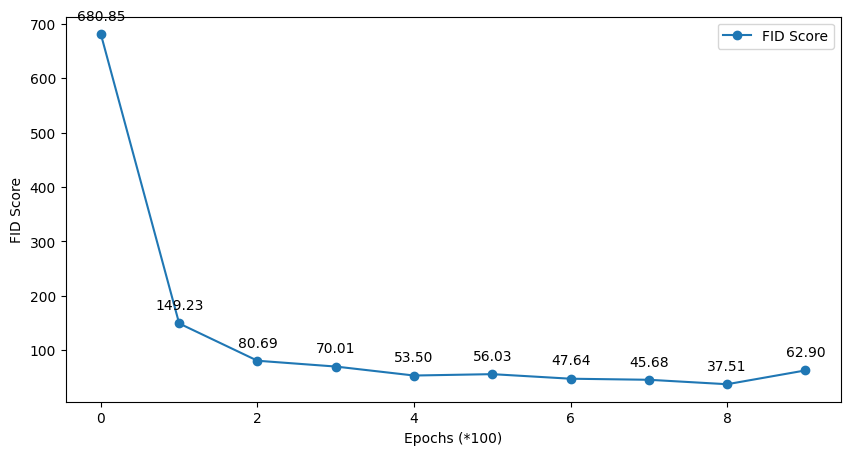

1/1 [==============================] - 0s 18ms/step


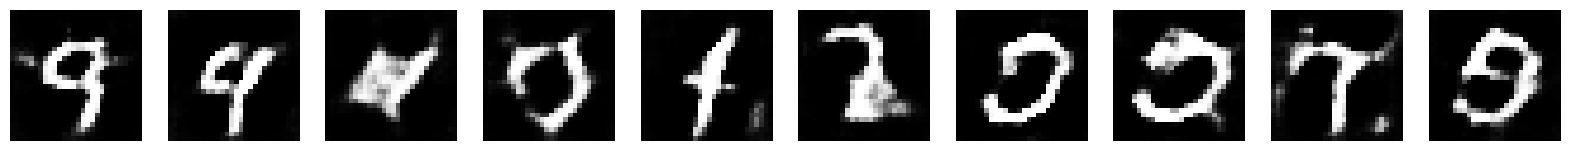

In [51]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [52]:
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000)

32/32 [==============================] - 1s 21ms/step
0 [D loss: 0.6951979994773865, acc.: 26.5625%] [G loss: 0.6606264710426331] [FID: 738.465906419401]
32/32 [==============================] - 1s 23ms/step
100 [D loss: 0.5744972229003906, acc.: 71.875%] [G loss: 1.528660774230957] [FID: 138.4933815768412]
32/32 [==============================] - 1s 25ms/step
200 [D loss: 0.6610679626464844, acc.: 56.25%] [G loss: 0.9324938058853149] [FID: 85.35058550083511]
32/32 [==============================] - 1s 22ms/step
300 [D loss: 0.6332841217517853, acc.: 67.1875%] [G loss: 1.022825002670288] [FID: 65.6724068430234]
1/1 [==============================] - 0s 88ms/step


32/32 [==============================] - 1s 22ms/step
400 [D loss: 0.5710557103157043, acc.: 73.4375%] [G loss: 1.0388057231903076] [FID: 60.22383460816]
32/32 [==============================] - 1s 23ms/step
500 [D loss: 0.7171903848648071, acc.: 60.9375%] [G loss: 1.2435297966003418] [FID: 52.14781934983298]
32/32 [==============================] - 1s 24ms/step
600 [D loss: 0.5936269760131836, acc.: 64.0625%] [G loss: 1.1235352754592896] [FID: 45.37574414420405]
1/1 [==============================] - 0s 32ms/step


32/32 [==============================] - 1s 22ms/step
700 [D loss: 0.7313937842845917, acc.: 50.0%] [G loss: 1.0419658422470093] [FID: 41.16603782665429]
32/32 [==============================] - 1s 20ms/step
800 [D loss: 0.6260365843772888, acc.: 67.1875%] [G loss: 0.9158105850219727] [FID: 42.17416298039424]
32/32 [==============================] - 1s 23ms/step
900 [D loss: 0.6298937499523163, acc.: 68.75%] [G loss: 0.8511985540390015] [FID: 35.872494902698136]
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 29ms/step
Total training time: 2627.38 seconds


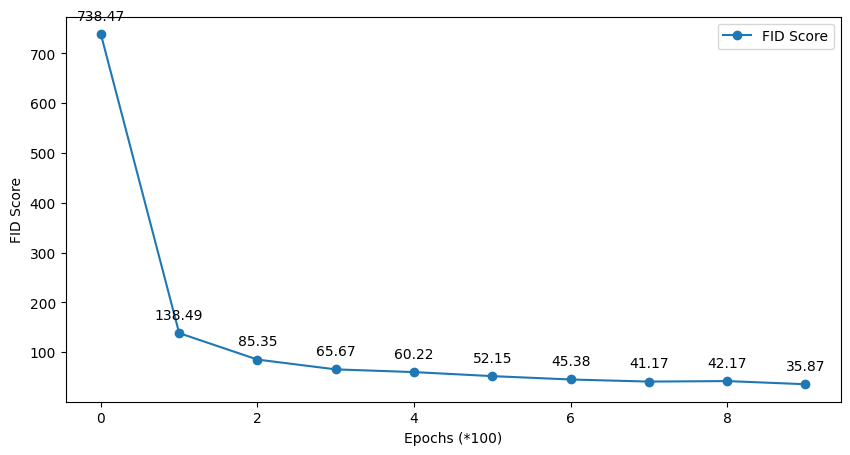

1/1 [==============================] - 0s 28ms/step


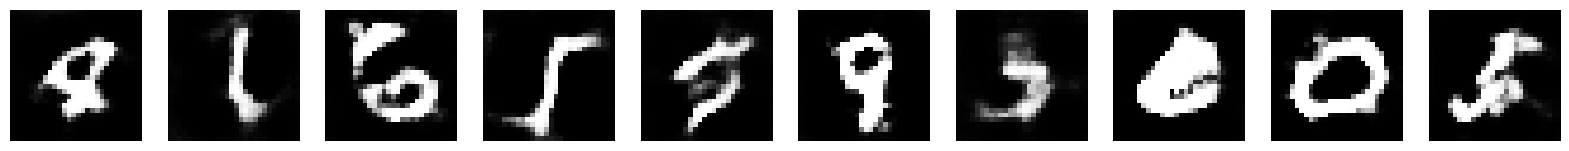

In [53]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [54]:
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000)

32/32 [==============================] - 1s 22ms/step
0 [D loss: 0.6955826580524445, acc.: 20.3125%] [G loss: 0.6600677967071533] [FID: 713.493603905172]
32/32 [==============================] - 1s 24ms/step
100 [D loss: 0.6923918426036835, acc.: 50.0%] [G loss: 0.681605339050293] [FID: 161.72887453257243]
32/32 [==============================] - 1s 21ms/step
200 [D loss: 0.6983476877212524, acc.: 59.375%] [G loss: 0.8355567455291748] [FID: 97.11829606617614]
32/32 [==============================] - 1s 22ms/step
300 [D loss: 0.6783803701400757, acc.: 60.9375%] [G loss: 0.7451547384262085] [FID: 82.91696152801667]
1/1 [==============================] - 0s 89ms/step


32/32 [==============================] - 1s 19ms/step
400 [D loss: 0.707796573638916, acc.: 51.5625%] [G loss: 0.8825207352638245] [FID: 67.48928925443354]
32/32 [==============================] - 1s 21ms/step
500 [D loss: 0.6624104380607605, acc.: 59.375%] [G loss: 0.8189991116523743] [FID: 52.711934800201234]
32/32 [==============================] - 1s 19ms/step
600 [D loss: 0.7052831649780273, acc.: 51.5625%] [G loss: 0.8538609147071838] [FID: 72.64556916732718]
1/1 [==============================] - 0s 26ms/step


32/32 [==============================] - 1s 22ms/step
700 [D loss: 0.6777442097663879, acc.: 59.375%] [G loss: 0.8421388864517212] [FID: 55.748299292322386]
32/32 [==============================] - 1s 18ms/step
800 [D loss: 0.6651098728179932, acc.: 65.625%] [G loss: 0.7575069665908813] [FID: 50.012912012220866]
32/32 [==============================] - 1s 21ms/step
900 [D loss: 0.6390371322631836, acc.: 68.75%] [G loss: 0.7519131898880005] [FID: 34.724227378944]
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step
Total training time: 2586.91 seconds


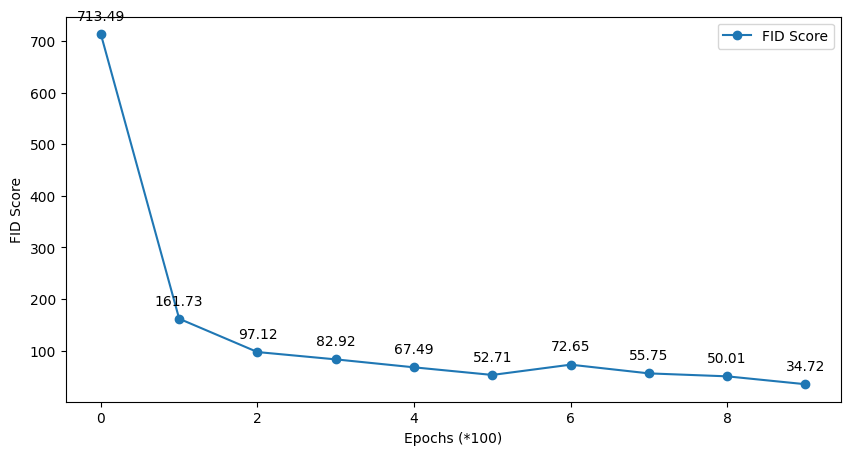

1/1 [==============================] - 0s 21ms/step


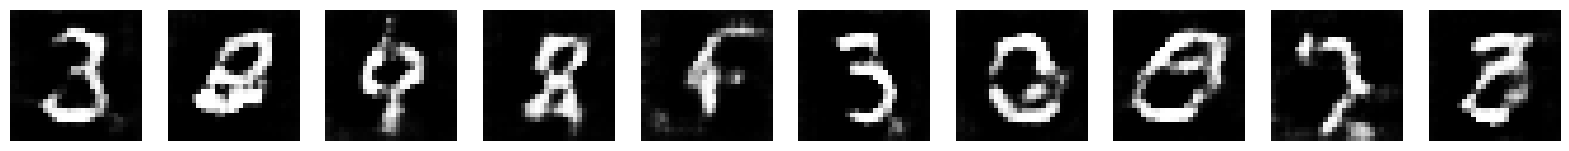

In [55]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()


**为什么gan模型准确率到达100%后， fid反而变得更大了**

这是一个很常见的问题，表示判别器变得过于强大，使得生成器难以学习到好的特征。这种情况被称为判别器崩溃。以下是一些常见原因和可能的解决方法：

原因：

	1.	判别器过于强大：判别器的准确率达到100%意味着它能完美地区分真实图像和生成图像，这对生成器是不利的，因为生成器需要通过欺骗判别器来提高自身的性能。
	2.	生成器训练不足：生成器可能没有足够的机会进行训练，导致它生成的图像质量没有改善。
	3.	损失函数的问题：标准的交叉熵损失可能会导致不稳定的训练，尤其是在判别器非常强大的情况下。

解决方法：

	1.	平衡生成器和判别器的训练：
	•	可以在每次训练生成器时训练判别器多次，反之亦然。
	•	限制判别器的能力，例如通过减少判别器的层数或神经元数量。
	2.	使用改进的GAN架构：
	•	Wasserstein GAN (WGAN)：使用Earth-Mover’s距离作为损失函数，改善训练的稳定性。
	•	WGAN-GP (Gradient Penalty)：在WGAN的基础上添加梯度惩罚，进一步提高训练稳定性。
	•	LSGAN (Least Squares GAN)：使用最小二乘损失，替代交叉熵损失，能够缓解训练不稳定的问题。
	3.	标签平滑（Label Smoothing）：对真实标签和假标签进行轻微的扰动，防止判别器过于自信。
	4.	对抗性训练技巧：
	•	随机噪声：在训练判别器时对其输入添加少量噪声，防止其过拟合。
	•	提前停止判别器的训练：在判别器的准确率达到一定值后停止其训练，给生成器更多的机会进行学习。

以下是改进后的代码，使用Wasserstein GAN（WGAN）并添加梯度惩罚（WGAN-GP）：

## Different Optimization

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from scipy.linalg import sqrtm
import numpy as np
import time
import matplotlib.pyplot as plt

np.random.seed(1000)
tf.random.set_seed(1000)

# input 100
# output 28*28*1

def build_generator():
    model = Sequential()
    
    # increase the dimension
    model.add(Dense(7*7*128, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(1, kernel_size=7, activation='tanh', padding='same'))

    return model

# input 28*28*1
# output 1

def build_discriminator():
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

# Load and preprocess the MNIST dataset
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)

# Calculate FID function
def calculate_fid(real_images, fake_images):
    act1 = real_images.reshape((real_images.shape[0], -1))
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    
    act2 = fake_images.reshape((fake_images.shape[0], -1))
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

def train_gan(epochs=1000, batch_size=64, p_epoch=100):
    generator = build_generator()
    discriminator = build_discriminator()

    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    # using half batches for the discriminator ensures balanced and efficient training, 
    # better memory management, and more stable training dynamics in GANs.
    half_batch = int(batch_size / 2)
    
    d_losses = []
    g_losses = []
    d_acc = []
    fid_scores = []  # List to store FID scores
    
    start_time = time.time()  # Record the start time

    for epoch in range(epochs):
        # Select a random half batch of real images
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        # Generate a half batch of new fake images
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        # Train the discriminator
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_y)

        # Record the losses
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_acc.append(d_loss[1] * 100)
        
        # Calculate FID every p_epoch epochs
        if epoch % p_epoch == 0:
            noise = np.random.normal(0, 1, (1000, 100))
            fake_images = generator.predict(noise)
            fid = calculate_fid(x_train[:1000], fake_images)
            fid_scores.append(fid)
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}] [FID: {fid}]")
    
    end_time = time.time()  # Record the end time
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    return generator, d_losses, g_losses, d_acc, fid_scores

## Different Regulation